# THIS NOTEBOOK:
### Analyze the Customer Service Tweets on Twitter
#### (The Kernel 'https://www.kaggle.com/psbots/customer-support-meets-spacy-universe' was used while creating this notebook )

Content
The dataset is a CSV, where each row is a tweet. The different columns are described below. Every conversation included has at least one request from a consumer and at least one response from a company. Which user IDs are company user IDs can be calculated using the inbound field.

tweet_id: 
A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

author_id: 
A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

inbound: 
Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

created_at: 
Date and time when the tweet was sent.

text: 
Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like __email__.

response_tweet_id: 
IDs of tweets that are responses to this tweet, comma-separated.

in_response_to_tweet_id: 
ID of the tweet this tweet is in response to, if any.

### Created By: George J. Conidis || Created On: January 25th, 2020 || Last Modified: January 25th, 2020

In [ ]:
import re
import os
import string 
import numpy as np
import pandas as pd
import matplotlib
#matplotlib.style.use('ggplot') ## G: removed and replaced with the code two lines below
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
width = 0.75
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.axis('off')
from nltk.corpus import stopwords
from textblob import TextBlob
import scattertext as st
import spacy
import spacy_cld
import json 
from ast import literal_eval

## Setting up the language detector for English (disabeling the tagger and ner) and creating
# the pipeline
nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
language_detector = spacy_cld.LanguageDetector()
nlp_cld.add_pipe(language_detector)

from IPython.display import IFrame
from IPython.core.display import display, HTML
from collections import Counter
from tqdm import tqdm_notebook as tqdm  # cool progress bars
tqdm().pandas()  # Enable tracking of progress in dataframe `apply` calls

import time

In [227]:
# Ensure the Jupyter Notebooks fills the web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Setting up various path variables
data_path = '/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/CustomerSupportTwitter'
data_generated_path = '/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/cleaned_generated/'
notebook_path = '/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/notebooks'

In [3]:
# Importing the Customer Service Twitter Data Set
os.chdir(data_path)
CS_Tweets_raw = pd.read_csv('twcs.csv', encoding='utf-8')

In [ ]:
CS_Tweets_raw.columns

## Generating The FULL TWEET Dataframe

In [ ]:
## Feature Engineering

def feature(df) :
    df['word_count'] = df['text'].apply(lambda x : len(x.split()))
    df['char_count'] = df['text'].apply(lambda x : len(x.replace(" ","")))
    df['word_density'] = df['word_count'] / (df['char_count'] + 1)
    df['punc_count'] = df['text'].apply(lambda x : len([a for a in x if a in string.punctuation]))
    df['total_length'] = df['text'].apply(len)
    df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    df['num_exclamation_marks'] = df['text'].apply(lambda x: x.count('!'))
    df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))
    df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    df['num_symbols'] = df['text'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
    df['num_unique_words'] = df['text'].apply(lambda x: len(set(w for w in x.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['word_count']
    df["word_unique_percent"] =  df["num_unique_words"]*100/df['word_count']
    return df

test = feature(CS_Tweets_raw)

In [ ]:
test.columns

In [ ]:
## Now creating a dataframe for ALL Tweets and their corresponding tweet ID
df_Tweets = pd.DataFrame([])
df_Tweets["Author_ID"]  = CS_Tweets_raw['author_id']
df_Tweets["Tweet_ID"]   = CS_Tweets_raw['tweet_id']
df_Tweets["Tweet_Text"] = CS_Tweets_raw["text"]


In [ ]:
## Including the time of the tweet in the full 'df_Tweets' dataframe
from datetime import datetime
import time
df_Tweets["Time_Created"] = CS_Tweets_raw["created_at"].apply(lambda x : int(datetime.strptime(x, "%a %b %d %H:%M:%S %z %Y").strftime('%s')))

## Training the Sentiment Analysis Model

In [ ]:
# Tweet_Emo_Preds = pipeline.predict(df_Tweets["Tweet_Text"]) # Predicting the emotions of ALL Tweets (numpy array)

In [ ]:
## Now Training the Sentiment Analysis Predictor (devloped in EmotionalSentiment_Data_Analysis_USAirlines.ipynb)

import numpy as np
import os

#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [ ]:
# Importing the dataset with pandas

# Changing the working directory to the raw data directory
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/US_Airline_Sentiment')
data_temp = pd.read_csv('Tweets.csv')
os.chdir(notebook_path)

In [ ]:
# Minimalist appraoch to labelling the above data set: 
# Create a binary classification scheme = the headline has a "+" or "-" emotional response.
## Only collect the responses that gave a positive or negative emotional response from the airline

# data_pn = data_temp[data_temp.airline_sentiment != 'neutral'] 
# data_pn.airline_sentiment.unique(), data_pn.shape  

# Droping labels with nan and converting them
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp['negativereason_confidence'] = data_temp.negativereason_confidence.round(0).astype(int)
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp.negativereason_confidence.unique()


# # Gathering the text and labels

text = data_temp.text.copy(deep=True)
labels_confvalues = data_temp.negativereason_confidence
labels_confvalues.unique()
# # Pre-processing labels. Removing "inf" and nan
labels_confvalues.replace([np.inf, -np.inf], np.nan)
labels_confvalues.dropna()

# # Seperating the labels by seperating the confidence labels to be:
# # negative > 0.5, positive is <= 0.5
labels_confvalues.dropna(how='all', inplace=True)
labels = labels_confvalues.round(0).astype(int)
filter_text = labels.index
text = text[filter_text]

# Printing the number of each class:
print("The total number of tweets are:", labels.shape[0])
print("The number (out of 5000) of negative emotional headlines =", labels.shape[0] - labels.sum())
print("The number (out of 5000) of positive emotional headlines =", labels.sum())
print("The niave classification (1 class fit to all) is =", 1-2111.0/7397)

In [ ]:
# Forcing a balance dataset -- NIAVELY REMOVING POSITIVE TWEETS To BALANCE THE DATASET

## Splitting the Data into a Training, Validation, and Test Set
## Fractions are: Training = 80%, Validation = 10%, Test = 10 %

from sklearn.model_selection import train_test_split  


## For the time being, the following code forces the training, validation, and test data sets are balanced
num_pos_labels = labels.sum() # 1418 headlines
num_neg_labels = labels.shape[0] - num_pos_labels # 3582 headlines
num_pos_labels_2drop = num_pos_labels - num_neg_labels # 2164 headlines
print(num_pos_labels)
print(num_neg_labels)
print(num_pos_labels_2drop)
# cnt = 0

index_pos = labels[labels == 1].index
index_neg = labels[labels == 0].index
labels_temp_bal_pos = labels[index_pos[num_pos_labels_2drop:]]
labels_temp_bal_neg = labels[index_neg]

labels_temp_bal = labels_temp_bal_neg.combine(labels_temp_bal_pos, max, fill_value=0)

print("The total length of the label series = ", labels_temp_bal.shape)
print("The total number of positive labels =",labels_temp_bal.sum())
labels_temp_bal.loc[14638], labels.loc[14638]

## Ensuring we use the appropriate text from the balanced labeled series
labels_temp_bal_indices = labels_temp_bal.index
text_bal = text[labels_temp_bal_indices]

# cnt = 0
# for i in range(labels_temp_bal.shape[0]):
#     if labels_temp_bal.iloc[i] == 1 and cnt < (num_pos_labels_2drop+1):
#         labels_temp_bal[i].drop(inplace=True)
#         cnt += 1

# index_Label0 = data_temp_bal.index[data_temp_bal['BinaryEmoLabel'] == 0].tolist()


# Labels = data_temp.BinaryEmoLabel
# X_train, X_test, y_train, y_test = train_test_split(data_temp, Labels, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

In [ ]:
## Combining all the above text pre-processing into one function 

def text_processing(headline):
    
    #Generating the list of words in the headline (hastags and other punctuations removed)
    def form_sentence(headline):
        headline_blob = TextBlob(headline)
        return ' '.join(headline_blob.words)
    new_headline = form_sentence(headline)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(headline):
        headline_list = [ele for ele in headline.split() if ele != 'user']
        clean_tokens = [t for t in headline_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_headline = no_user_alpha(new_headline)
    
    #Normalizing the words in headlines 
    def normalization(headline_list):
        lem = WordNetLemmatizer()
        normalized_headline = []
        for word in headline_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_headline.append(normalized_text)
        return normalized_headline
    
    
    return normalization(no_punc_headline)

In [ ]:
def Int2EmotionConverter(IntEmo):
    """
    Converts the integer value of the emotion predicted to the emotions word in English
    """
    EmoWords = pd.DataFrame(['Happy','Sad'])
    return EmoWords.iloc[IntEmo][0]

In [ ]:
# scikit-learn: Pre-defining a workflow of algorithm (Niave-Bayse Classifier)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),                      # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
### Trainiing Model ####
msg_train, msg_test, label_train, label_test = train_test_split(text_bal, labels_temp_bal, test_size=0.1)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))
# What would the accuracy of the Training Data Set is we niavely set all labels to 0
print("The accuracy of labelling all headlines NEGATIVE is:",1-label_train.sum()/len(label_train))

print("This model's accuracy is better than the Niave assumption by:", accuracy_score(predictions,label_test) - 1+label_train.sum()/len(label_train)) 

In [ ]:
##################################################################################################
## Sanity Check: Does each Tweet have text attached to it?
##################################################################################################
# cnt = 0
#for i in range(df_Tweets.shape[0]):
#     (df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].empty == False)
# cnt_empty = 0
# for j in range(df_Tweets.shape[0]):
#     print("The index =",j)
#     Tweet_ID_Temp = df_Tweets.Tweet_ID.iloc[j]
#     cnt_empty += int((df_Tweets.loc[df`_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].empty == False))

## Creating the Twitter Conversation DataFrame

In [ ]:
# Re-arranging the dataframe to have customer request and response pairings
Initial_Request = CS_Tweets_raw[pd.isnull(CS_Tweets_raw.in_response_to_tweet_id) & CS_Tweets_raw.inbound]

Req_Res = pd.merge(Initial_Request, CS_Tweets_raw, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter by response replies (i.e by companies responses)
Req_Res = Req_Res[Req_Res.inbound_y ^ True]
print(f'Data shape: {Req_Res.shape}')
Req_Res.head(100)

In [ ]:
## Removing the anonymous screen names from dataset
def sn_replace(match):
    _sn = match.group(2).lower()
    if not _sn.isnumeric():
        # This is a company screen name
        return match.group(1) + match.group(2)
    return ''

sn_re = re.compile('(\W@|^@)([a-zA-Z0-9_]+)')
print("Removing anonymized screen names in X...")
Req_Res["text_x"] = Req_Res.text_x.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))
print("Removing anonymized screen names in Y...")
Req_Res["text_y"] = Req_Res.text_y.progress_apply(lambda txt: sn_re.sub(sn_replace, txt))

In [ ]:
# The number of Customer Service (CS) tweet responses for each company
count = Req_Res.groupby("author_id_y")["text_x"].count()
c = count[count>10000].plot(kind='barh',figsize=(10, 8), color='#619CFF', zorder=2,)# width=width,)
c.set_ylabel('')
# plt.show()

In [ ]:
## List all the companies to find all airlines (Sentiment was trained on: American, Delta, SouthWest, United, US Airways, Virgin)
Req_Res["author_id_y"].unique()

In [ ]:
## For the time being let us stick with AmericanAir services
AmericanAir_Req_Res = Req_Res[Req_Res["author_id_y"]=="AmericanAir"]
DeltaAir_Req_Res = Req_Res[Req_Res["author_id_y"]=="Delta"]
British_Airways_Req_Res = Req_Res[Req_Res["author_id_y"]=="British_Airways"]
SouthwestAir_Req_Res = Req_Res[Req_Res["author_id_y"] == "SouthwestAir"]
VirginAtlantic_Req_Res = Req_Res[Req_Res["author_id_y"] == "VirginAtlantic"]
AlaskaAir_Req_Res = Req_Res[Req_Res["author_id_y"] == "AlaskaAir"]
VirginAmerica_Req_Res = Req_Res[Req_Res["author_id_y"] == "VirginAmerica"]
JetBlue_Req_Res = Req_Res[Req_Res["author_id_y"] == "JetBlue"]
AirAsiaSupport = Req_Res[Req_Res["author_id_y"] == "AirAsiaSupport"]

# New Additions to the array

AmazonHelp_Req_Res = Req_Res[Req_Res['author_id_y'] == "AmazonHelp"]
AppleSupport_Req_Res = Req_Res[Req_Res['author_id_y'] == "AppleSupport"]

Airline_List = [AmericanAir_Req_Res, DeltaAir_Req_Res, British_Airways_Req_Res, SouthwestAir_Req_Res, VirginAtlantic_Req_Res, AlaskaAir_Req_Res, VirginAmerica_Req_Res, JetBlue_Req_Res, AirAsiaSupport, AmazonHelp_Req_Res, AppleSupport_Req_Res ]

SUB_Req_Res = pd.concat(Airline_List, axis=0)

print(SUB_Req_Res.shape[0])

SUB_Req_Res.head()

In [ ]:
# Interestingly the Data Set has tweets in many languages
# -- Imposing the requirement that we only use tweets written in English

# nlp_cld = spacy.load('en',disable_pipes=["tagger","ner"])
# language_detector = spacy_cld.LanguageDetector()
# nlp_cld.add_pipe(language_detector)

# Creating a mask for the Language Values
mask = []
try:
    for i,doc in tqdm(enumerate(nlp_cld.pipe(SUB_Req_Res["text_x"], batch_size=1024))):
            if 'en' not in doc._.languages or len(doc._.languages) != 1:
                mask.append(False)
            else:
                mask.append(True)
except Exception:
    print("excepted ")

In [ ]:
# Applying the mask created above 
# AmericanAir_Req_Res = AmericanAir_Req_Res[mask]
SUB_Req_Res['in_response_to_tweet_id_y'].astype(int)
type(SUB_Req_Res['in_response_to_tweet_id_y'].iloc[0])
# SUB_Req_Res_NoNaN = AmericanAir_Req_Res.dropna(how='all')
# print(SUB_Req_Res_NoNaN.shape)
len(mask), SUB_Req_Res['text_x'].shape
SUB_Req_Res.sample(frac=0.0005)

In [ ]:
# Generating The Conversation Array: Contains the Tweet_IDs for each conversations
SUB_Conv = pd.DataFrame([])
SUB_Conv["Author_ID"]   = SUB_Req_Res['author_id_x']      # Adding the Author if the first tweet
SUB_Conv["Tweet_ID_Initial"]  = SUB_Req_Res['tweet_id_x'] # Adding the first tweet's id
SUB_Conv["Full_Response_Tweet_IDs"] = ""
print(SUB_Conv.shape)

for i in range(SUB_Req_Res.shape[0]):
    # Tweets from Company to Customer
    temp_list_x = []
    temp_list_x = SUB_Req_Res['response_tweet_id_x'].iloc[i].split(",")
    temp_list_x = list(map(int, temp_list_x))
    # Tweets from Customer to Company
    temp_list_y = []
    if str(SUB_Req_Res['response_tweet_id_y'].iloc[i]) != 'nan':
        temp_list_y = SUB_Req_Res['response_tweet_id_y'].iloc[i].split(",")
        temp_list_y = list(map(int, temp_list_y))
    # Combining Tweet ID Lists from Customer and Company
    SUB_Conv['Full_Response_Tweet_IDs'].iloc[i] = temp_list_x+temp_list_y

## Saving the Request and Response Dataframe and the Conversational Dataframe
SUB_Req_Res.to_csv('SUB_Req_Res.csv')
SUB_Conv.to_csv('SUB_Conv.csv')

In [ ]:
SUB_Conv

In [ ]:
os.chdir(data_generated_path)
SUB_Req_Res = pd.read_csv("SUB_Req_Res.csv")
SUB_Conv = pd.read_csv("SUB_Conv.csv")

## Returning to the Customer Service Tweets

In [ ]:
### LOADING THE EMOTIONAL SENTIMENT LABELS FOR EACH TWEET ###
#np.save('Tweet_Emo_Preds_250120.csv',Tweet_Emo_Preds)
os.chdir(data_generated_path)
Tweet_Emo_Preds = np.load("Tweet_Emo_Preds_250120.csv.npy")
df_Tweets["Emotion"] = Tweet_Emo_Preds ## The emotional prediction = "Positive" = 1 , "Negative" = 0
## Replacing the number valued emotions with the associated words: 0 - "Pos" and 1 - "Neg"
df_Tweets['Emotion'] = df_Tweets['Emotion'].replace(0,'Pos')
df_Tweets['Emotion'] = df_Tweets['Emotion'].replace(1,'Neg')
df_Tweets['Emotion'].unique()
df_Tweets.to_csv("df_Tweets.csv")

In [ ]:
df_Tweets = pd.read_csv("df_Tweets.csv")

In [ ]:
df_Tweets.columns, SUB_Conv.columns

In [ ]:
SUB_Conv["Convo_Length"] = "" # the number of tweets in the conversations
SUB_Conv["Tweets"] = pd.Series([]) # A list all the tweets in the conversations
SUB_Conv["Emotions"] = pd.Series([]) # A vector of the emotions in chronological order (same order as tweets in "Tweets")
SUB_Conv["Author_ID_List"] = pd.Series([])
SUB_Conv["Final_Convo_Length"] = 0
SUB_Conv["Times_Created"] = pd.Series([])
for i in range(SUB_Conv.shape[0]):
#for i in range(100):
    print(i)
    # Resetting variables
    convo_len = 0 
    Tweet_Text_Temp = [] # declaring/resetting the list for tweet text
    Tweet_Emotion_Temp = [] # declaring/resetting the list for the emotional predictions
    Tweet_Convo_AuthorIDs = [] 
    Tweet_Times_Created = []
    convo_cnt = 0
    
    convo_len = len(SUB_Conv['Full_Response_Tweet_IDs'].iloc[i]) # Conversation length (# of Tweets)
    if convo_len > 0:
        SUB_Conv["Convo_Length"].iloc[i] = convo_len # Saving the Length of the Conversation
        Tweet_IDs_Temp = SUB_Conv.iloc[i].Full_Response_Tweet_IDs # Comversation Tweet IDs
        Initial_Tweet_ID_Temp = SUB_Conv["Tweet_ID_Initial"].iloc[i] # The First Tweet ID
        Initial_Tweet_Time_Created = df_Tweets[df_Tweets["Tweet_ID"] == Initial_Tweet_ID_Temp].Time_Created
        
        if df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Tweet_Text'].empty == False:
            Tweet_Text_Temp.append((df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Tweet_Text'].iloc[0])) # First Tweet's Text
            Tweet_Emotion_Temp.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Emotion'].iloc[0])
            Tweet_Convo_AuthorIDs.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Author_ID'].iloc[0])
            Tweet_Times_Created.append(df_Tweets.loc[df_Tweets['Tweet_ID'] == Initial_Tweet_ID_Temp, 'Time_Created'].iloc[0])
            for j in range(convo_len):
                Tweet_ID_Temp = Tweet_IDs_Temp[j]
                if (df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].empty == False):
                    Tweet_Text_Temp.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Tweet_Text'].iloc[0] )
                    Tweet_Emotion_Temp.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Emotion'].iloc[0] )
                    Tweet_Convo_AuthorIDs.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Author_ID'].iloc[0] )
                    Tweet_Times_Created.append( df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Time_Created'].iloc[0] )
                    convo_cnt += 1
#                     print(cnt)
    
            SUB_Conv["Tweets"].iloc[i] = Tweet_Text_Temp
#             print(Tweet_Emotion_Temp)
#             print("The type of the Emotion 'list?':", type(Tweet_Emotion_Temp))
#             print("The type of the Tweets 'list'?:", type(Tweet_Text_Temp))
            SUB_Conv["Emotions"].iloc[i] = Tweet_Emotion_Temp # The List of Emotions corresponding to (and preserving the order of) the Tweet_IDs
            SUB_Conv["Author_ID_List"].iloc[i] = Tweet_Convo_AuthorIDs # The list of authors in the order of the Tweet_IDs
            SUB_Conv["Final_Convo_Length"].iloc[i] = convo_cnt # This is the number of tweets that were found to exist for the conversation
            SUB_Conv["Times_Created"].iloc[i] = [str(i) for i in Tweet_Times_Created]
    #else SUB_Conv.drop(SUB_Conv.iloc[i]):
SUB_Conv.to_csv("SUB_Conv_Combined.csv")

In [631]:
#SUB_Conv[0:100]
# df_Tweets.loc[df_Tweets['Tweet_ID'] == Tweet_ID_Temp, 'Author_ID'].iloc[0]
SUB_Conv = pd.read_csv("SUB_Conv_Combined.csv")
# SUB_Conv[SUB_Conv["Final_Convo_Length"] >= 4]

In [632]:
# Checking to see if there are duplicate rows
len(SUB_Conv['Tweet_ID_Initial'].unique()), SUB_Conv.shape[0]
# test = SUB_Conv.drop_duplicates(inplace=False, keep=False)
SUB_Conv_Unique =  SUB_Conv.drop_duplicates(subset='Tweet_ID_Initial', keep="first", inplace=False)
SUB_Conv_Unique.to_csv("SUB_Conv_CombUni.csv")

In [633]:
SUB_Conv_Unique.shape, SUB_Conv.shape

((257853, 10), (275360, 10))

In [634]:
SUB_Conv['Author_ID_List'].iloc[0]

"['115905', 'AmericanAir']"

In [635]:
## Removing Conversations which have more than two Authors
# len(np.unique(SUB_Conv['Author_ID_List'].iloc[i]))
# SUB_Conv_Unique["Author_Num"] = SUB_Conv_Unique["Author_ID_List"].apply(lambda x: len(np.unique(x)))
# SUB_Conv_2PerUnique = SUB_Conv_Unique[SUB_Conv_Unique["Author_Num"] == 2]

In [636]:
## If you are loading the data from a saved file you will need to convert the list of Authors from a string to a list
import ast
ast.literal_eval(SUB_Conv_Unique['Author_ID_List'].iloc[1])
SUB_Conv_Unique["Author_ID_List"] = SUB_Conv_Unique["Author_ID_List"].apply(lambda x: ast.literal_eval(x))
SUB_Conv_Unique["Author_Num"] = SUB_Conv_Unique["Author_ID_List"].apply(lambda x: len(np.unique(x)))
SUB_Conv_2PerUnique = SUB_Conv_Unique[SUB_Conv_Unique["Author_Num"] == 2]
SUB_Conv_2PerUnique.to_csv('SUB_Conv_2PerUnique.csv',index=False)

In [637]:
SUB_Conv_2PerUnique.shape

(251962, 11)

## PLACING THE CUTOFF FOR CONVERSATIONS WHICH HAVE AT LEAST 4 TWEETS

In [638]:
## REMOVING ALL CONVERSATIONS SHORTER THAN 4 TWEETS
SUB_Conv_CombUni = pd.read_csv('SUB_Conv_2PerUnique.csv',index_col=[0])
SUB_Conv_2PerUnique_4MORE = SUB_Conv_CombUni[SUB_Conv_CombUni['Final_Convo_Length'] >= 3] # Recall the Final Covo Length DOES NOT count initial tweet

In [639]:
SUB_Conv_CombUni.iloc[0]

Author_ID                                                             115905
Tweet_ID_Initial                                                        1002
Full_Response_Tweet_IDs                                               [1001]
Convo_Length                                                               1
Tweets                     ['Ben Tennyson and an American Airlines pilot....
Emotions                                                      ['Pos', 'Pos']
Author_ID_List                                     ['115905', 'AmericanAir']
Final_Convo_Length                                                         1
Times_Created                                   ['1509501724', '1509503045']
Author_Num                                                                 2
Name: 161, dtype: object

## ENSURING THAT EACH AUTHOR HAS SENT AT LEAST 2 TWEETS EACH

In [640]:
# Adding in the numbers of tweets by the customer and the agents
SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Num'] = SUB_Conv_2PerUnique_4MORE['Author_ID_List'].apply( lambda x: list(Counter(literal_eval(x)).values())[0])
SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Num'] = SUB_Conv_2PerUnique_4MORE['Author_ID_List'].apply( lambda x: list(Counter(literal_eval(x)).values())[1])

In [641]:
# Ensuring the conversations have at least two tweets from the customer and the agent
SUB_Conv_2PerUnique_4MORE = SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Num'] > 1]
SUB_Conv_2PerUnique_4MORE = SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Num'] > 1]

In [642]:
SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Num'].unique(), SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Num'].unique(), SUB_Conv_2PerUnique_4MORE['Final_Convo_Length'].unique()

(array([ 2,  3,  5,  4,  6, 14,  7, 19, 21,  8, 10,  9]),
 array([2, 3, 4, 5, 6]),
 array([ 3,  4,  5,  6,  7, 15,  8, 20, 22,  9, 11, 10]))

In [643]:
SUB_Conv_2PerUnique_4MORE.shape

(4871, 12)

In [644]:
temp = SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Emotions']
# print( type(literal_eval(temp.values[0])) )
print( literal_eval(SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Emotions'].values[0])  )

['Pos', 'Neg', 'Pos', 'Pos']


In [645]:
# Chronologically ordering Tweets and corresponding sentiment
# NOTE: ensure the tweets are ordered chronologically
# SUB_Conv_2PerUnique_4MORE['Times_Created']
# i = 33827

SUB_Conv_2PerUnique_4MORE['Times_Created_Sorted'] = pd.Series([]) 
SUB_Conv_2PerUnique_4MORE['Emotions_Sorted'] = pd.Series([]) 
SUB_Conv_2PerUnique_4MORE['Tweets_Sorted'] = pd.Series([])
SUB_Conv_2PerUnique_4MORE['Author_ID_List_Sorted'] = pd.Series([])

for i in range(SUB_Conv_2PerUnique_4MORE.shape[0]):
    print("PerComp =", i*100.0/SUB_Conv_2PerUnique_4MORE.shape[0])
    temp_tweet_ID_initial = SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'].iloc[i]
    # Time Ordering Array
    temp_times = literal_eval(SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Times_Created'].iloc[0])
    temp_index = np.argsort(temp_times)
    times_ordered = sorted(temp_times) # temp_times[temp_index]
    
    # Array Chronologically Reordering
    temp_Emos = literal_eval(SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Emotions'].values[0])
    temp_Emos_ordered = sorted(temp_Emos) # [ temp_Emos.iloc[0][i] for i in temp_index]
    temp_Tweets = literal_eval(SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Tweets'].values[0])
    temp_Tweets_ordered = [temp_Tweets[i] for i in temp_index]
    temp_Author_list = literal_eval(SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE['Tweet_ID_Initial'] == temp_tweet_ID_initial ]['Author_ID_List'].values[0])
    temp_Author_list_ordered = [temp_Author_list[i] for i in temp_index]
    
    SUB_Conv_2PerUnique_4MORE['Times_Created_Sorted'].iloc[i] = times_ordered# list(times_ordered.astype(str)) # pd.Series(np.ndarray.tolist(times_ordered))
    SUB_Conv_2PerUnique_4MORE['Emotions_Sorted'].iloc[i] = temp_Emos_ordered
    SUB_Conv_2PerUnique_4MORE['Tweets_Sorted'].iloc[i] = temp_Tweets_ordered
    SUB_Conv_2PerUnique_4MORE['Author_ID_List_Sorted'].iloc[i] = temp_Author_list_ordered

SUB_Conv_2PerUnique_4MORE.to_csv("SUB_Conv_2PerUnique_4MORE.csv",index=False)    
print("Completed!!")

PerComp = 0.0
PerComp = 0.020529665366454525
PerComp = 0.04105933073290905
PerComp = 0.06158899609936358
PerComp = 0.0821186614658181
PerComp = 0.10264832683227264
PerComp = 0.12317799219872716
PerComp = 0.1437076575651817
PerComp = 0.1642373229316362
PerComp = 0.18476698829809074
PerComp = 0.20529665366454528
PerComp = 0.22582631903099978
PerComp = 0.24635598439745432
PerComp = 0.2668856497639088
PerComp = 0.2874153151303634
PerComp = 0.3079449804968179
PerComp = 0.3284746458632724
PerComp = 0.34900431122972697
PerComp = 0.3695339765961815
PerComp = 0.390063641962636
PerComp = 0.41059330732909055
PerComp = 0.43112297269554506
PerComp = 0.45165263806199957
PerComp = 0.47218230342845413
PerComp = 0.49271196879490864
PerComp = 0.5132416341613631
PerComp = 0.5337712995278177
PerComp = 0.5543009648942723
PerComp = 0.5748306302607268
PerComp = 0.5953602956271813
PerComp = 0.6158899609936358
PerComp = 0.6364196263600903
PerComp = 0.6569492917265448
PerComp = 0.6774789570929994
PerComp = 0.69

PerComp = 6.158899609936358
PerComp = 6.179429275302812
PerComp = 6.1999589406692674
PerComp = 6.220488606035722
PerComp = 6.241018271402176
PerComp = 6.261547936768631
PerComp = 6.282077602135085
PerComp = 6.30260726750154
PerComp = 6.323136932867994
PerComp = 6.3436665982344485
PerComp = 6.3641962636009035
PerComp = 6.384725928967358
PerComp = 6.405255594333813
PerComp = 6.425785259700267
PerComp = 6.446314925066721
PerComp = 6.466844590433176
PerComp = 6.48737425579963
PerComp = 6.507903921166085
PerComp = 6.52843358653254
PerComp = 6.548963251898994
PerComp = 6.569492917265449
PerComp = 6.590022582631903
PerComp = 6.610552247998358
PerComp = 6.631081913364812
PerComp = 6.651611578731266
PerComp = 6.6721412440977215
PerComp = 6.692670909464176
PerComp = 6.71320057483063
PerComp = 6.733730240197085
PerComp = 6.754259905563539
PerComp = 6.774789570929994
PerComp = 6.795319236296448
PerComp = 6.8158489016629025
PerComp = 6.8363785670293575
PerComp = 6.856908232395812
PerComp = 6.877437

PerComp = 13.077396838431534
PerComp = 13.097926503797988
PerComp = 13.118456169164443
PerComp = 13.138985834530898
PerComp = 13.159515499897351
PerComp = 13.180045165263806
PerComp = 13.200574830630261
PerComp = 13.221104495996716
PerComp = 13.24163416136317
PerComp = 13.262163826729624
PerComp = 13.28269349209608
PerComp = 13.303223157462533
PerComp = 13.323752822828988
PerComp = 13.344282488195443
PerComp = 13.364812153561896
PerComp = 13.385341818928351
PerComp = 13.405871484294806
PerComp = 13.42640114966126
PerComp = 13.446930815027715
PerComp = 13.46746048039417
PerComp = 13.487990145760625
PerComp = 13.508519811127078
PerComp = 13.529049476493533
PerComp = 13.549579141859988
PerComp = 13.570108807226442
PerComp = 13.590638472592897
PerComp = 13.611168137959352
PerComp = 13.631697803325805
PerComp = 13.65222746869226
PerComp = 13.672757134058715
PerComp = 13.69328679942517
PerComp = 13.713816464791623
PerComp = 13.734346130158078
PerComp = 13.754875795524534
PerComp = 13.7754054

PerComp = 19.40053377129953
PerComp = 19.421063436665982
PerComp = 19.44159310203244
PerComp = 19.462122767398892
PerComp = 19.482652432765345
PerComp = 19.503182098131802
PerComp = 19.523711763498255
PerComp = 19.54424142886471
PerComp = 19.564771094231165
PerComp = 19.58530075959762
PerComp = 19.605830424964072
PerComp = 19.62636009033053
PerComp = 19.646889755696982
PerComp = 19.667419421063435
PerComp = 19.687949086429892
PerComp = 19.708478751796346
PerComp = 19.7290084171628
PerComp = 19.749538082529256
PerComp = 19.77006774789571
PerComp = 19.790597413262162
PerComp = 19.81112707862862
PerComp = 19.831656743995072
PerComp = 19.852186409361526
PerComp = 19.872716074727983
PerComp = 19.893245740094436
PerComp = 19.913775405460893
PerComp = 19.934305070827346
PerComp = 19.9548347361938
PerComp = 19.975364401560256
PerComp = 19.99589406692671
PerComp = 20.016423732293163
PerComp = 20.03695339765962
PerComp = 20.057483063026073
PerComp = 20.078012728392526
PerComp = 20.09854239375898

PerComp = 25.80578936563334
PerComp = 25.826319030999795
PerComp = 25.846848696366248
PerComp = 25.867378361732705
PerComp = 25.887908027099158
PerComp = 25.90843769246561
PerComp = 25.928967357832068
PerComp = 25.94949702319852
PerComp = 25.970026688564975
PerComp = 25.99055635393143
PerComp = 26.011086019297885
PerComp = 26.03161568466434
PerComp = 26.052145350030795
PerComp = 26.072675015397248
PerComp = 26.093204680763705
PerComp = 26.11373434613016
PerComp = 26.13426401149661
PerComp = 26.15479367686307
PerComp = 26.17532334222952
PerComp = 26.195853007595975
PerComp = 26.216382672962432
PerComp = 26.236912338328885
PerComp = 26.25744200369534
PerComp = 26.277971669061795
PerComp = 26.29850133442825
PerComp = 26.319030999794702
PerComp = 26.33956066516116
PerComp = 26.360090330527612
PerComp = 26.380619995894065
PerComp = 26.401149661260522
PerComp = 26.421679326626975
PerComp = 26.442208991993432
PerComp = 26.462738657359886
PerComp = 26.48326832272634
PerComp = 26.50379798809279

PerComp = 32.08786696776843
PerComp = 32.10839663313488
PerComp = 32.128926298501334
PerComp = 32.14945596386779
PerComp = 32.16998562923424
PerComp = 32.1905152946007
PerComp = 32.211044959967154
PerComp = 32.23157462533361
PerComp = 32.25210429070006
PerComp = 32.272633956066514
PerComp = 32.29316362143297
PerComp = 32.31369328679943
PerComp = 32.33422295216588
PerComp = 32.354752617532334
PerComp = 32.37528228289879
PerComp = 32.39581194826524
PerComp = 32.4163416136317
PerComp = 32.436871278998154
PerComp = 32.45740094436461
PerComp = 32.47793060973106
PerComp = 32.498460275097514
PerComp = 32.51898994046397
PerComp = 32.53951960583043
PerComp = 32.56004927119688
PerComp = 32.580578936563334
PerComp = 32.60110860192979
PerComp = 32.62163826729624
PerComp = 32.642167932662694
PerComp = 32.662697598029155
PerComp = 32.68322726339561
PerComp = 32.70375692876206
PerComp = 32.724286594128515
PerComp = 32.74481625949497
PerComp = 32.76534592486143
PerComp = 32.78587559022788
PerComp = 32

PerComp = 38.51365222746869
PerComp = 38.53418189283515
PerComp = 38.5547115582016
PerComp = 38.57524122356806
PerComp = 38.59577088893451
PerComp = 38.61630055430096
PerComp = 38.63683021966742
PerComp = 38.65735988503388
PerComp = 38.67788955040033
PerComp = 38.69841921576678
PerComp = 38.71894888113324
PerComp = 38.73947854649969
PerComp = 38.76000821186614
PerComp = 38.780537877232604
PerComp = 38.80106754259906
PerComp = 38.82159720796551
PerComp = 38.842126873331964
PerComp = 38.86265653869842
PerComp = 38.88318620406488
PerComp = 38.90371586943133
PerComp = 38.924245534797784
PerComp = 38.94477520016424
PerComp = 38.96530486553069
PerComp = 38.985834530897144
PerComp = 39.006364196263604
PerComp = 39.02689386163006
PerComp = 39.04742352699651
PerComp = 39.067953192362964
PerComp = 39.08848285772942
PerComp = 39.10901252309587
PerComp = 39.12954218846233
PerComp = 39.150071853828784
PerComp = 39.17060151919524
PerComp = 39.19113118456169
PerComp = 39.211660849928144
PerComp = 39.

PerComp = 44.93943748716896
PerComp = 44.95996715253541
PerComp = 44.980496817901866
PerComp = 45.001026483268326
PerComp = 45.02155614863478
PerComp = 45.04208581400123
PerComp = 45.062615479367686
PerComp = 45.08314514473414
PerComp = 45.10367481010059
PerComp = 45.12420447546705
PerComp = 45.144734140833506
PerComp = 45.16526380619996
PerComp = 45.18579347156641
PerComp = 45.206323136932866
PerComp = 45.22685280229932
PerComp = 45.24738246766578
PerComp = 45.26791213303223
PerComp = 45.288441798398686
PerComp = 45.30897146376514
PerComp = 45.32950112913159
PerComp = 45.350030794498046
PerComp = 45.37056045986451
PerComp = 45.39109012523096
PerComp = 45.41161979059741
PerComp = 45.43214945596387
PerComp = 45.45267912133032
PerComp = 45.47320878669678
PerComp = 45.49373845206323
PerComp = 45.51426811742969
PerComp = 45.53479778279614
PerComp = 45.55532744816259
PerComp = 45.57585711352905
PerComp = 45.59638677889551
PerComp = 45.61691644426196
PerComp = 45.637446109628414
PerComp = 45

PerComp = 51.44734140833504
PerComp = 51.467871073701495
PerComp = 51.488400739067956
PerComp = 51.50893040443441
PerComp = 51.52946006980086
PerComp = 51.549989735167316
PerComp = 51.57051940053377
PerComp = 51.59104906590023
PerComp = 51.61157873126668
PerComp = 51.632108396633136
PerComp = 51.65263806199959
PerComp = 51.67316772736604
PerComp = 51.693697392732496
PerComp = 51.714227058098956
PerComp = 51.73475672346541
PerComp = 51.75528638883186
PerComp = 51.775816054198316
PerComp = 51.79634571956477
PerComp = 51.81687538493122
PerComp = 51.83740505029768
PerComp = 51.857934715664136
PerComp = 51.87846438103059
PerComp = 51.89899404639704
PerComp = 51.919523711763496
PerComp = 51.94005337712995
PerComp = 51.96058304249641
PerComp = 51.98111270786286
PerComp = 52.001642373229316
PerComp = 52.02217203859577
PerComp = 52.04270170396222
PerComp = 52.06323136932868
PerComp = 52.08376103469514
PerComp = 52.10429070006159
PerComp = 52.12482036542804
PerComp = 52.145350030794496
PerComp =

PerComp = 57.91418599876822
PerComp = 57.93471566413467
PerComp = 57.95524532950113
PerComp = 57.975774994867585
PerComp = 57.99630466023404
PerComp = 58.01683432560049
PerComp = 58.037363990966945
PerComp = 58.0578936563334
PerComp = 58.07842332169986
PerComp = 58.09895298706631
PerComp = 58.119482652432765
PerComp = 58.14001231779922
PerComp = 58.16054198316567
PerComp = 58.18107164853213
PerComp = 58.201601313898585
PerComp = 58.22213097926504
PerComp = 58.24266064463149
PerComp = 58.263190309997945
PerComp = 58.2837199753644
PerComp = 58.30424964073086
PerComp = 58.32477930609731
PerComp = 58.345308971463766
PerComp = 58.36583863683022
PerComp = 58.38636830219667
PerComp = 58.406897967563125
PerComp = 58.427427632929586
PerComp = 58.44795729829604
PerComp = 58.46848696366249
PerComp = 58.489016629028946
PerComp = 58.5095462943954
PerComp = 58.53007595976186
PerComp = 58.55060562512831
PerComp = 58.571135290494766
PerComp = 58.59166495586122
PerComp = 58.61219462122767
PerComp = 58.

PerComp = 64.40156025456785
PerComp = 64.42208991993431
PerComp = 64.44261958530076
PerComp = 64.46314925066721
PerComp = 64.48367891603367
PerComp = 64.50420858140012
PerComp = 64.52473824676657
PerComp = 64.54526791213303
PerComp = 64.56579757749948
PerComp = 64.58632724286593
PerComp = 64.6068569082324
PerComp = 64.62738657359886
PerComp = 64.64791623896531
PerComp = 64.66844590433176
PerComp = 64.68897556969821
PerComp = 64.70950523506467
PerComp = 64.73003490043112
PerComp = 64.75056456579757
PerComp = 64.77109423116403
PerComp = 64.79162389653048
PerComp = 64.81215356189693
PerComp = 64.8326832272634
PerComp = 64.85321289262986
PerComp = 64.87374255799631
PerComp = 64.89427222336276
PerComp = 64.91480188872922
PerComp = 64.93533155409567
PerComp = 64.95586121946212
PerComp = 64.97639088482858
PerComp = 64.99692055019503
PerComp = 65.01745021556148
PerComp = 65.03797988092794
PerComp = 65.05850954629439
PerComp = 65.07903921166086
PerComp = 65.09956887702731
PerComp = 65.120098542

PerComp = 70.9710531718333
PerComp = 70.99158283719976
PerComp = 71.01211250256621
PerComp = 71.03264216793266
PerComp = 71.05317183329912
PerComp = 71.07370149866557
PerComp = 71.09423116403202
PerComp = 71.11476082939848
PerComp = 71.13529049476493
PerComp = 71.15582016013138
PerComp = 71.17634982549784
PerComp = 71.1968794908643
PerComp = 71.21740915623076
PerComp = 71.23793882159721
PerComp = 71.25846848696366
PerComp = 71.27899815233012
PerComp = 71.29952781769657
PerComp = 71.32005748306302
PerComp = 71.34058714842948
PerComp = 71.36111681379593
PerComp = 71.38164647916238
PerComp = 71.40217614452884
PerComp = 71.4227058098953
PerComp = 71.44323547526176
PerComp = 71.46376514062821
PerComp = 71.48429480599467
PerComp = 71.50482447136112
PerComp = 71.52535413672757
PerComp = 71.54588380209402
PerComp = 71.56641346746048
PerComp = 71.58694313282693
PerComp = 71.60747279819338
PerComp = 71.62800246355984
PerComp = 71.6485321289263
PerComp = 71.66906179429276
PerComp = 71.68959145965

PerComp = 77.2941901047013
PerComp = 77.31471977006775
PerComp = 77.3352494354342
PerComp = 77.35577910080066
PerComp = 77.37630876616711
PerComp = 77.39683843153357
PerComp = 77.41736809690002
PerComp = 77.43789776226647
PerComp = 77.45842742763293
PerComp = 77.47895709299938
PerComp = 77.49948675836583
PerComp = 77.52001642373229
PerComp = 77.54054608909875
PerComp = 77.56107575446521
PerComp = 77.58160541983166
PerComp = 77.60213508519811
PerComp = 77.62266475056457
PerComp = 77.64319441593102
PerComp = 77.66372408129747
PerComp = 77.68425374666393
PerComp = 77.70478341203038
PerComp = 77.72531307739683
PerComp = 77.74584274276329
PerComp = 77.76637240812975
PerComp = 77.78690207349621
PerComp = 77.80743173886266
PerComp = 77.82796140422911
PerComp = 77.84849106959557
PerComp = 77.86902073496202
PerComp = 77.88955040032847
PerComp = 77.91008006569493
PerComp = 77.93060973106138
PerComp = 77.95113939642783
PerComp = 77.97166906179429
PerComp = 77.99219872716074
PerComp = 78.012728392

PerComp = 83.6583863683022
PerComp = 83.67891603366866
PerComp = 83.69944569903511
PerComp = 83.71997536440156
PerComp = 83.74050502976802
PerComp = 83.76103469513447
PerComp = 83.78156436050092
PerComp = 83.80209402586738
PerComp = 83.82262369123383
PerComp = 83.84315335660028
PerComp = 83.86368302196674
PerComp = 83.8842126873332
PerComp = 83.90474235269966
PerComp = 83.92527201806611
PerComp = 83.94580168343256
PerComp = 83.96633134879902
PerComp = 83.98686101416547
PerComp = 84.00739067953192
PerComp = 84.02792034489838
PerComp = 84.04845001026483
PerComp = 84.06897967563128
PerComp = 84.08950934099774
PerComp = 84.11003900636419
PerComp = 84.13056867173066
PerComp = 84.15109833709711
PerComp = 84.17162800246356
PerComp = 84.19215766783002
PerComp = 84.21268733319647
PerComp = 84.23321699856292
PerComp = 84.25374666392938
PerComp = 84.27427632929583
PerComp = 84.29480599466228
PerComp = 84.31533566002874
PerComp = 84.33586532539519
PerComp = 84.35639499076166
PerComp = 84.376924656

PerComp = 89.98152330117018
PerComp = 90.00205296653665
PerComp = 90.0225826319031
PerComp = 90.04311229726956
PerComp = 90.06364196263601
PerComp = 90.08417162800247
PerComp = 90.10470129336892
PerComp = 90.12523095873537
PerComp = 90.14576062410183
PerComp = 90.16629028946828
PerComp = 90.18681995483473
PerComp = 90.20734962020119
PerComp = 90.22787928556764
PerComp = 90.2484089509341
PerComp = 90.26893861630056
PerComp = 90.28946828166701
PerComp = 90.30999794703347
PerComp = 90.33052761239992
PerComp = 90.35105727776637
PerComp = 90.37158694313283
PerComp = 90.39211660849928
PerComp = 90.41264627386573
PerComp = 90.43317593923219
PerComp = 90.45370560459864
PerComp = 90.4742352699651
PerComp = 90.49476493533156
PerComp = 90.51529460069801
PerComp = 90.53582426606447
PerComp = 90.55635393143092
PerComp = 90.57688359679737
PerComp = 90.59741326216383
PerComp = 90.61794292753028
PerComp = 90.63847259289673
PerComp = 90.65900225826319
PerComp = 90.67953192362964
PerComp = 90.7000615889

PerComp = 96.36624923013756
PerComp = 96.38677889550401
PerComp = 96.40730856087046
PerComp = 96.42783822623691
PerComp = 96.44836789160337
PerComp = 96.46889755696982
PerComp = 96.48942722233627
PerComp = 96.50995688770273
PerComp = 96.53048655306918
PerComp = 96.55101621843563
PerComp = 96.57154588380209
PerComp = 96.59207554916856
PerComp = 96.61260521453501
PerComp = 96.63313487990146
PerComp = 96.65366454526792
PerComp = 96.67419421063437
PerComp = 96.69472387600082
PerComp = 96.71525354136728
PerComp = 96.73578320673373
PerComp = 96.75631287210018
PerComp = 96.77684253746664
PerComp = 96.79737220283309
PerComp = 96.81790186819954
PerComp = 96.83843153356601
PerComp = 96.85896119893246
PerComp = 96.87949086429892
PerComp = 96.90002052966537
PerComp = 96.92055019503182
PerComp = 96.94107986039828
PerComp = 96.96160952576473
PerComp = 96.98213919113118
PerComp = 97.00266885649764
PerComp = 97.02319852186409
PerComp = 97.04372818723054
PerComp = 97.06425785259701
PerComp = 97.0847875

In [622]:
# SUB_Conv_2PerUnique.to_csv('SUB_Conv_2PerUnique.csv')
os.chdir(data_generated_path)
SUB_Conv_2PerUnique_4MORE = pd.read_csv("SUB_Conv_2PerUnique_4MORE.csv")

In [646]:
SUB_Conv_2PerUnique_4MORE.iloc[0]

Author_ID                                                             169682
Tweet_ID_Initial                                                      253596
Full_Response_Tweet_IDs                             [253594, 253597, 253595]
Convo_Length                                                               3
Tweets                     ['@AmericanAir   Well done ignoring discrimina...
Emotions                                        ['Neg', 'Pos', 'Pos', 'Neg']
Author_ID_List             ['169682', 'AmericanAir', 'AmericanAir', '1696...
Final_Convo_Length                                                         3
Times_Created              ['1507190931', '1507240432', '1507191527', '15...
Author_Num                                                                 2
Customer_Tweet_Num                                                         2
Agent_Tweet_Num                                                            2
Times_Created_Sorted        [1507190931, 1507191527, 1507240432, 1507248050]

In [624]:
# type(SUB_Conv_2PerUnique['Author_ID_List_Sorted'].iloc[0]), SUB_Conv_2PerUnique['Author_ID_List_Sorted'].iloc[0]

## Converting the list saved a strings to lists
SUB_Conv_2PerUnique["Author_ID_List_Sorted"] = SUB_Conv_2PerUnique["Author_ID_List_Sorted"].apply(lambda x: literal_eval(x))

KeyError: 'Author_ID_List_Sorted'

In [647]:
# Converting the String Emotions to integer values
SUB_Conv_2PerUnique_4MORE['Emotions_Sorted_Ints'] = SUB_Conv_2PerUnique_4MORE['Emotions_Sorted'].apply(lambda x: [0 if i == 'Pos' else 1 for i in x] )
# SUB_Conv_2PerUnique_4MORE['Emotions_Sorted_Ints']

In [648]:
SUB_Conv_2PerUnique_4MORE['Emotions_Sorted_Ints']

Unnamed: 0
65645        [1, 1, 0, 0]
90990     [1, 1, 1, 1, 1]
110219       [1, 1, 1, 0]
111259       [1, 1, 1, 0]
124305       [0, 0, 0, 0]
               ...       
872968    [1, 1, 1, 0, 0]
873548       [0, 0, 0, 0]
874716       [1, 1, 0, 0]
61645        [1, 0, 0, 0]
711591       [1, 0, 0, 0]
Name: Emotions_Sorted_Ints, Length: 4871, dtype: object

In [649]:
# Now adding the all the emotional (integer) lists together
from operator import add
from itertools import zip_longest
sum_list = []
for i in range(SUB_Conv_2PerUnique_4MORE.shape[0]):
    list_temp = SUB_Conv_2PerUnique_4MORE['Emotions_Sorted_Ints'].iloc[i]
    sum_list = [sum(n) for n in zip_longest(sum_list, list_temp, fillvalue=0)]

In [650]:
sum_list

[3658,
 2117,
 800,
 220,
 50,
 15,
 8,
 6,
 3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0]

In [651]:
SUB_Conv_2PerUnique_4MORE.head(1)

,Author_ID,Tweet_ID_Initial,Full_Response_Tweet_IDs,Convo_Length,Tweets,Emotions,Author_ID_List,Final_Convo_Length,Times_Created,Author_Num,Customer_Tweet_Num,Agent_Tweet_Num,Times_Created_Sorted,Emotions_Sorted,Tweets_Sorted,Author_ID_List_Sorted,Emotions_Sorted_Ints
Unnamed: 0,,,,,,,,,,,,,,,,,
65645,169682,253596,"[253594, 253597, 253595]",3,['@AmericanAir Well done ignoring discrimina...,"['Neg', 'Pos', 'Pos', 'Neg']","['169682', 'AmericanAir', 'AmericanAir', '1696...",3,"['1507190931', '1507240432', '1507191527', '15...",2,2,2,"[1507190931, 1507191527, 1507240432, 1507248050]","[Neg, Neg, Pos, Pos]",[@AmericanAir Well done ignoring discriminat...,"[169682, AmericanAir, AmericanAir, 169682]","[1, 1, 0, 0]"


In [652]:
## Counting the number of negative tweets from the customer and the agent
SUB_Conv_2PerUnique_4MORE['Customer_Neg_Tweet_Nums'] = 0 # Adding the number of neg. customer tweets
SUB_Conv_2PerUnique_4MORE['Agent_Neg_Tweet_Nums'] = 0 # Adding the number of neg. agent tweets
SUB_Conv_2PerUnique_4MORE['Customer_Negativity_Value'] = 0 # The Customer Negativity Value
SUB_Conv_2PerUnique_4MORE['Agent_Negativity_Value'] = 0 # The Agent Negativity Value
SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Sentiment_List'] = pd.Series([])
SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Sentiment_List'] = pd.Series([])
SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Indices'] = pd.Series([])
SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Indices'] = pd.Series([])
time0 = time.time()
for i in range(SUB_Conv_2PerUnique_4MORE.shape[0]): 
    print("The Percentage Completed = ", i*100.0/SUB_Conv_2PerUnique_4MORE.shape[0] )
    print("The Time Elapsed is = ", time.time()-time0)
    temp_customer_ID, temp_agent_ID = np.unique(literal_eval(SUB_Conv_2PerUnique_4MORE.Author_ID_List.iloc[i]))
#     temp_customer_ID = literal_eval(SUB_Conv_2PerUnique_4MORE['Author_ID_List'].iloc[i])[0]
#     temp_agent_ID = literal_eval(SUB_Conv_2PerUnique_4MORE['Author_ID_List'].iloc[i])[1]
    temp_author_list_sorted  = SUB_Conv_2PerUnique_4MORE['Author_ID_List_Sorted'].iloc[i]
    temp_emotional_ints = SUB_Conv_2PerUnique_4MORE['Emotions_Sorted_Ints'].iloc[i]
    temp_final_convo_length = SUB_Conv_2PerUnique_4MORE['Final_Convo_Length'].iloc[i]
    temp_Customer_Sent_list = []
    temp_Customer_Tweet_indices = []
    temp_Agent_Sent_list = []
    temp_Agent_Tweet_indices = []
    
    # Determining the sentiment 'list' for the customer and the agent in the conversation
    for j in range(temp_final_convo_length+1): # +1 b/c the convo length counts after initial tweet
        if temp_author_list_sorted[j] == temp_customer_ID:
            temp_Customer_Sent_list.append(temp_emotional_ints[j])
            temp_Customer_Tweet_indices.append(j)
        elif temp_author_list_sorted[j] == temp_agent_ID:
            temp_Agent_Sent_list.append(temp_emotional_ints[j])
            temp_Agent_Tweet_indices.append(j)
            
    # Counting the TOTAL (SUM) of the sentiment for the customer and the agent over the entir conversation
    for j in range(len(temp_author_list_sorted)):
        if temp_author_list_sorted[j] == temp_customer_ID and temp_emotional_ints[j] == 1:
            SUB_Conv_2PerUnique_4MORE['Customer_Neg_Tweet_Nums'].iloc[i] += 1
        elif temp_author_list_sorted[j] == temp_agent_ID and temp_emotional_ints[j] == 1:
            SUB_Conv_2PerUnique_4MORE['Agent_Neg_Tweet_Nums'].iloc[i] += 1
    
    # Placing the output lists in the pandas frame row associated with the conversation under investigation
    SUB_Conv_2PerUnique_4MORE['Customer_Negativity_Value'].iloc[i] = SUB_Conv_2PerUnique_4MORE['Customer_Neg_Tweet_Nums'].iloc[i] / temp_final_convo_length
    SUB_Conv_2PerUnique_4MORE['Agent_Negativity_Value'].iloc[i] = SUB_Conv_2PerUnique_4MORE['Agent_Neg_Tweet_Nums'].iloc[i] / temp_final_convo_length
#     print(type(temp_Customer_Sent_list)) ## It is a 'list' type 
    SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Sentiment_List'].iloc[i] = str(temp_Customer_Sent_list)
#     SUB_Conv_2PerUnique_4MORE.at[i, 'Customer_Tweet_Sentiment_List'] = temp_Customer_Sent_list
    SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Sentiment_List'].iloc[i] = str(temp_Agent_Sent_list)
    SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Indices'].iloc[i] = str(temp_Customer_Tweet_indices)
    SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Indices'].iloc[i] = str(temp_Agent_Tweet_indices)
    
SUB_Conv_2PerUnique_4MORE.to_csv("SUB_Conv_2PerUnique_4MORE.csv",index=False)    
print("The SUB Array has been saved---Completed!!")    

The Percentage Completed =  0.0
The Time Elapsed is =  0.0004241466522216797
The Percentage Completed =  0.020529665366454525
The Time Elapsed is =  0.022844314575195312
The Percentage Completed =  0.04105933073290905
The Time Elapsed is =  0.029714107513427734
The Percentage Completed =  0.06158899609936358
The Time Elapsed is =  0.032302141189575195
The Percentage Completed =  0.0821186614658181
The Time Elapsed is =  0.034430742263793945
The Percentage Completed =  0.10264832683227264
The Time Elapsed is =  0.03639101982116699
The Percentage Completed =  0.12317799219872716
The Time Elapsed is =  0.03916144371032715
The Percentage Completed =  0.1437076575651817
The Time Elapsed is =  0.0414729118347168
The Percentage Completed =  0.1642373229316362
The Time Elapsed is =  0.04443240165710449
The Percentage Completed =  0.18476698829809074
The Time Elapsed is =  0.0476374626159668
The Percentage Completed =  0.20529665366454528
The Time Elapsed is =  0.0496826171875
The Percentage Co

The Percentage Completed =  3.90063641962636
The Time Elapsed is =  0.41318178176879883
The Percentage Completed =  3.9211660849928145
The Time Elapsed is =  0.4155457019805908
The Percentage Completed =  3.941695750359269
The Time Elapsed is =  0.4173746109008789
The Percentage Completed =  3.9622254157257237
The Time Elapsed is =  0.41950392723083496
The Percentage Completed =  3.9827550810921784
The Time Elapsed is =  0.42137813568115234
The Percentage Completed =  4.0032847464586325
The Time Elapsed is =  0.42334914207458496
The Percentage Completed =  4.023814411825088
The Time Elapsed is =  0.4251589775085449
The Percentage Completed =  4.044344077191542
The Time Elapsed is =  0.42687320709228516
The Percentage Completed =  4.064873742557996
The Time Elapsed is =  0.42911624908447266
The Percentage Completed =  4.085403407924451
The Time Elapsed is =  0.43340206146240234
The Percentage Completed =  4.105933073290905
The Time Elapsed is =  0.4359245300292969
The Percentage Complet

The Percentage Completed =  6.07678094847054
The Time Elapsed is =  0.6259462833404541
The Percentage Completed =  6.097310613836995
The Time Elapsed is =  0.6276617050170898
The Percentage Completed =  6.117840279203449
The Time Elapsed is =  0.6294078826904297
The Percentage Completed =  6.138369944569903
The Time Elapsed is =  0.6309404373168945
The Percentage Completed =  6.158899609936358
The Time Elapsed is =  0.6324830055236816
The Percentage Completed =  6.179429275302812
The Time Elapsed is =  0.6343498229980469
The Percentage Completed =  6.1999589406692674
The Time Elapsed is =  0.6361637115478516
The Percentage Completed =  6.220488606035722
The Time Elapsed is =  0.638401985168457
The Percentage Completed =  6.241018271402176
The Time Elapsed is =  0.642350435256958
The Percentage Completed =  6.261547936768631
The Time Elapsed is =  0.6450004577636719
The Percentage Completed =  6.282077602135085
The Time Elapsed is =  0.6467771530151367
The Percentage Completed =  6.3026

The Percentage Completed =  8.129747485115992
The Time Elapsed is =  0.8353958129882812
The Percentage Completed =  8.150277150482447
The Time Elapsed is =  0.8369979858398438
The Percentage Completed =  8.170806815848902
The Time Elapsed is =  0.8387303352355957
The Percentage Completed =  8.191336481215357
The Time Elapsed is =  0.8404765129089355
The Percentage Completed =  8.21186614658181
The Time Elapsed is =  0.842064380645752
The Percentage Completed =  8.232395811948265
The Time Elapsed is =  0.8440299034118652
The Percentage Completed =  8.25292547731472
The Time Elapsed is =  0.8458211421966553
The Percentage Completed =  8.273455142681174
The Time Elapsed is =  0.8475244045257568
The Percentage Completed =  8.293984808047629
The Time Elapsed is =  0.8495993614196777
The Percentage Completed =  8.314514473414084
The Time Elapsed is =  0.8531081676483154
The Percentage Completed =  8.335044138780537
The Time Elapsed is =  0.8551232814788818
The Percentage Completed =  8.35557

The Percentage Completed =  10.244303017860808
The Time Elapsed is =  1.0467040538787842
The Percentage Completed =  10.264832683227263
The Time Elapsed is =  1.0495524406433105
The Percentage Completed =  10.285362348593718
The Time Elapsed is =  1.051119327545166
The Percentage Completed =  10.305892013960172
The Time Elapsed is =  1.053307056427002
The Percentage Completed =  10.326421679326627
The Time Elapsed is =  1.055370807647705
The Percentage Completed =  10.346951344693082
The Time Elapsed is =  1.0571660995483398
The Percentage Completed =  10.367481010059535
The Time Elapsed is =  1.0587821006774902
The Percentage Completed =  10.38801067542599
The Time Elapsed is =  1.0605669021606445
The Percentage Completed =  10.408540340792445
The Time Elapsed is =  1.062396764755249
The Percentage Completed =  10.4290700061589
The Time Elapsed is =  1.0643742084503174
The Percentage Completed =  10.449599671525354
The Time Elapsed is =  1.0662517547607422
The Percentage Completed =  

The Percentage Completed =  12.19462122767399
The Time Elapsed is =  1.2581696510314941
The Percentage Completed =  12.215150893040443
The Time Elapsed is =  1.2604753971099854
The Percentage Completed =  12.235680558406898
The Time Elapsed is =  1.263458251953125
The Percentage Completed =  12.256210223773353
The Time Elapsed is =  1.2656137943267822
The Percentage Completed =  12.276739889139806
The Time Elapsed is =  1.267408847808838
The Percentage Completed =  12.297269554506261
The Time Elapsed is =  1.2707843780517578
The Percentage Completed =  12.317799219872716
The Time Elapsed is =  1.2737984657287598
The Percentage Completed =  12.338328885239171
The Time Elapsed is =  1.2769439220428467
The Percentage Completed =  12.358858550605625
The Time Elapsed is =  1.2790968418121338
The Percentage Completed =  12.37938821597208
The Time Elapsed is =  1.2813451290130615
The Percentage Completed =  12.399917881338535
The Time Elapsed is =  1.2835705280303955
The Percentage Completed 

The Percentage Completed =  14.124409772120714
The Time Elapsed is =  1.4643504619598389
The Percentage Completed =  14.144939437487169
The Time Elapsed is =  1.4659197330474854
The Percentage Completed =  14.165469102853624
The Time Elapsed is =  1.4674956798553467
The Percentage Completed =  14.185998768220077
The Time Elapsed is =  1.469217300415039
The Percentage Completed =  14.206528433586533
The Time Elapsed is =  1.4709854125976562
The Percentage Completed =  14.227058098952988
The Time Elapsed is =  1.4727144241333008
The Percentage Completed =  14.24758776431944
The Time Elapsed is =  1.4742884635925293
The Percentage Completed =  14.268117429685896
The Time Elapsed is =  1.475963830947876
The Percentage Completed =  14.288647095052351
The Time Elapsed is =  1.477954626083374
The Percentage Completed =  14.309176760418806
The Time Elapsed is =  1.4796979427337646
The Percentage Completed =  14.32970642578526
The Time Elapsed is =  1.481424331665039
The Percentage Completed = 

The Percentage Completed =  16.46479162389653
The Time Elapsed is =  1.6911606788635254
The Percentage Completed =  16.485321289262984
The Time Elapsed is =  1.69339919090271
The Percentage Completed =  16.50585095462944
The Time Elapsed is =  1.6950404644012451
The Percentage Completed =  16.526380619995894
The Time Elapsed is =  1.697023630142212
The Percentage Completed =  16.546910285362348
The Time Elapsed is =  1.699871301651001
The Percentage Completed =  16.567439950728804
The Time Elapsed is =  1.7027111053466797
The Percentage Completed =  16.587969616095258
The Time Elapsed is =  1.7049527168273926
The Percentage Completed =  16.60849928146171
The Time Elapsed is =  1.707190990447998
The Percentage Completed =  16.629028946828168
The Time Elapsed is =  1.7118580341339111
The Percentage Completed =  16.64955861219462
The Time Elapsed is =  1.713928461074829
The Percentage Completed =  16.670088277561074
The Time Elapsed is =  1.7157857418060303
The Percentage Completed =  16.

The Percentage Completed =  18.517758160541984
The Time Elapsed is =  1.8971366882324219
The Percentage Completed =  18.538287825908437
The Time Elapsed is =  1.899034023284912
The Percentage Completed =  18.55881749127489
The Time Elapsed is =  1.900953769683838
The Percentage Completed =  18.579347156641347
The Time Elapsed is =  1.9027349948883057
The Percentage Completed =  18.5998768220078
The Time Elapsed is =  1.9043598175048828
The Percentage Completed =  18.620406487374257
The Time Elapsed is =  1.9067015647888184
The Percentage Completed =  18.64093615274071
The Time Elapsed is =  1.9099738597869873
The Percentage Completed =  18.661465818107164
The Time Elapsed is =  1.9142303466796875
The Percentage Completed =  18.68199548347362
The Time Elapsed is =  1.917043924331665
The Percentage Completed =  18.702525148840074
The Time Elapsed is =  1.920123815536499
The Percentage Completed =  18.723054814206527
The Time Elapsed is =  1.9221670627593994
The Percentage Completed =  18

The Percentage Completed =  20.509135701088073
The Time Elapsed is =  2.103088617324829
The Percentage Completed =  20.529665366454527
The Time Elapsed is =  2.105137348175049
The Percentage Completed =  20.55019503182098
The Time Elapsed is =  2.106720447540283
The Percentage Completed =  20.570724697187437
The Time Elapsed is =  2.1084702014923096
The Percentage Completed =  20.59125436255389
The Time Elapsed is =  2.1104063987731934
The Percentage Completed =  20.611784027920343
The Time Elapsed is =  2.111994743347168
The Percentage Completed =  20.6323136932868
The Time Elapsed is =  2.1138694286346436
The Percentage Completed =  20.652843358653254
The Time Elapsed is =  2.115602493286133
The Percentage Completed =  20.673373024019707
The Time Elapsed is =  2.117614269256592
The Percentage Completed =  20.693902689386164
The Time Elapsed is =  2.119784355163574
The Percentage Completed =  20.714432354752617
The Time Elapsed is =  2.1239635944366455
The Percentage Completed =  20.7

The Percentage Completed =  23.77335249435434
The Time Elapsed is =  2.529890298843384
The Percentage Completed =  23.793882159720795
The Time Elapsed is =  2.5319643020629883
The Percentage Completed =  23.81441182508725
The Time Elapsed is =  2.534794807434082
The Percentage Completed =  23.834941490453705
The Time Elapsed is =  2.5395374298095703
The Percentage Completed =  23.85547115582016
The Time Elapsed is =  2.542008399963379
The Percentage Completed =  23.876000821186615
The Time Elapsed is =  2.5464000701904297
The Percentage Completed =  23.89653048655307
The Time Elapsed is =  2.5495412349700928
The Percentage Completed =  23.917060151919525
The Time Elapsed is =  2.552018165588379
The Percentage Completed =  23.93758981728598
The Time Elapsed is =  2.554241895675659
The Percentage Completed =  23.95811948265243
The Time Elapsed is =  2.557234287261963
The Percentage Completed =  23.97864914801889
The Time Elapsed is =  2.5611586570739746
The Percentage Completed =  23.999

The Percentage Completed =  26.811742968589613
The Time Elapsed is =  2.9499149322509766
The Percentage Completed =  26.832272633956066
The Time Elapsed is =  2.952082872390747
The Percentage Completed =  26.85280229932252
The Time Elapsed is =  2.954025983810425
The Percentage Completed =  26.873331964688976
The Time Elapsed is =  2.955976963043213
The Percentage Completed =  26.89386163005543
The Time Elapsed is =  2.9577860832214355
The Percentage Completed =  26.914391295421886
The Time Elapsed is =  2.9600982666015625
The Percentage Completed =  26.93492096078834
The Time Elapsed is =  2.962226629257202
The Percentage Completed =  26.955450626154793
The Time Elapsed is =  2.96427059173584
The Percentage Completed =  26.97598029152125
The Time Elapsed is =  2.9663941860198975
The Percentage Completed =  26.996509956887703
The Time Elapsed is =  2.968801498413086
The Percentage Completed =  27.017039622254156
The Time Elapsed is =  2.9708669185638428
The Percentage Completed =  27.0

The Percentage Completed =  28.823650174502156
The Time Elapsed is =  3.165658712387085
The Percentage Completed =  28.84417983986861
The Time Elapsed is =  3.167588949203491
The Percentage Completed =  28.864709505235066
The Time Elapsed is =  3.169386386871338
The Percentage Completed =  28.88523917060152
The Time Elapsed is =  3.1712262630462646
The Percentage Completed =  28.905768835967972
The Time Elapsed is =  3.172997236251831
The Percentage Completed =  28.92629850133443
The Time Elapsed is =  3.1747491359710693
The Percentage Completed =  28.946828166700882
The Time Elapsed is =  3.1765222549438477
The Percentage Completed =  28.967357832067336
The Time Elapsed is =  3.1784298419952393
The Percentage Completed =  28.987887497433793
The Time Elapsed is =  3.180353879928589
The Percentage Completed =  29.008417162800246
The Time Elapsed is =  3.182110548019409
The Percentage Completed =  29.0289468281667
The Time Elapsed is =  3.1840410232543945
The Percentage Completed =  29.0

The Percentage Completed =  30.794498049681792
The Time Elapsed is =  3.3714816570281982
The Percentage Completed =  30.815027715048245
The Time Elapsed is =  3.3740200996398926
The Percentage Completed =  30.8355573804147
The Time Elapsed is =  3.3760323524475098
The Percentage Completed =  30.856087045781155
The Time Elapsed is =  3.3780357837677
The Percentage Completed =  30.87661671114761
The Time Elapsed is =  3.3798468112945557
The Percentage Completed =  30.897146376514062
The Time Elapsed is =  3.3830580711364746
The Percentage Completed =  30.91767604188052
The Time Elapsed is =  3.385169744491577
The Percentage Completed =  30.938205707246972
The Time Elapsed is =  3.387075185775757
The Percentage Completed =  30.958735372613425
The Time Elapsed is =  3.389460802078247
The Percentage Completed =  30.979265037979882
The Time Elapsed is =  3.391500234603882
The Percentage Completed =  30.999794703346335
The Time Elapsed is =  3.39412522315979
The Percentage Completed =  31.020

The Percentage Completed =  32.76534592486143
The Time Elapsed is =  3.582348346710205
The Percentage Completed =  32.78587559022788
The Time Elapsed is =  3.584652900695801
The Percentage Completed =  32.806405255594335
The Time Elapsed is =  3.586996555328369
The Percentage Completed =  32.82693492096079
The Time Elapsed is =  3.5891072750091553
The Percentage Completed =  32.84746458632724
The Time Elapsed is =  3.590848207473755
The Percentage Completed =  32.867994251693695
The Time Elapsed is =  3.5929617881774902
The Percentage Completed =  32.888523917060155
The Time Elapsed is =  3.5960464477539062
The Percentage Completed =  32.90905358242661
The Time Elapsed is =  3.598968505859375
The Percentage Completed =  32.92958324779306
The Time Elapsed is =  3.601729393005371
The Percentage Completed =  32.950112913159515
The Time Elapsed is =  3.6041486263275146
The Percentage Completed =  32.97064257852597
The Time Elapsed is =  3.6067731380462646
The Percentage Completed =  32.991

The Percentage Completed =  36.37856702935742
The Time Elapsed is =  3.996825933456421
The Percentage Completed =  36.39909669472387
The Time Elapsed is =  3.998955488204956
The Percentage Completed =  36.419626360090334
The Time Elapsed is =  4.0010364055633545
The Percentage Completed =  36.44015602545679
The Time Elapsed is =  4.003098726272583
The Percentage Completed =  36.46068569082324
The Time Elapsed is =  4.0051538944244385
The Percentage Completed =  36.48121535618969
The Time Elapsed is =  4.007323503494263
The Percentage Completed =  36.50174502155615
The Time Elapsed is =  4.00956392288208
The Percentage Completed =  36.5222746869226
The Time Elapsed is =  4.011761665344238
The Percentage Completed =  36.54280435228906
The Time Elapsed is =  4.013776540756226
The Percentage Completed =  36.563334017655514
The Time Elapsed is =  4.017136573791504
The Percentage Completed =  36.58386368302197
The Time Elapsed is =  4.019388437271118
The Percentage Completed =  36.6043933483

The Percentage Completed =  40.01231779921987
The Time Elapsed is =  4.421318292617798
The Percentage Completed =  40.032847464586325
The Time Elapsed is =  4.423809051513672
The Percentage Completed =  40.05337712995278
The Time Elapsed is =  4.426009178161621
The Percentage Completed =  40.07390679531924
The Time Elapsed is =  4.427991628646851
The Percentage Completed =  40.09443646068569
The Time Elapsed is =  4.430102348327637
The Percentage Completed =  40.114966126052146
The Time Elapsed is =  4.433957099914551
The Percentage Completed =  40.1354957914186
The Time Elapsed is =  4.436267137527466
The Percentage Completed =  40.15602545678505
The Time Elapsed is =  4.4382452964782715
The Percentage Completed =  40.17655512215151
The Time Elapsed is =  4.439960479736328
The Percentage Completed =  40.197084787517966
The Time Elapsed is =  4.441859722137451
The Percentage Completed =  40.21761445288442
The Time Elapsed is =  4.4445013999938965
The Percentage Completed =  40.23814411

The Percentage Completed =  42.12687333196469
The Time Elapsed is =  4.630470275878906
The Percentage Completed =  42.14740299733114
The Time Elapsed is =  4.6324193477630615
The Percentage Completed =  42.167932662697595
The Time Elapsed is =  4.634795904159546
The Percentage Completed =  42.188462328064055
The Time Elapsed is =  4.636626243591309
The Percentage Completed =  42.20899199343051
The Time Elapsed is =  4.638543128967285
The Percentage Completed =  42.22952165879696
The Time Elapsed is =  4.640395164489746
The Percentage Completed =  42.250051324163415
The Time Elapsed is =  4.642147779464722
The Percentage Completed =  42.27058098952987
The Time Elapsed is =  4.643929958343506
The Percentage Completed =  42.29111065489632
The Time Elapsed is =  4.645938396453857
The Percentage Completed =  42.31164032026278
The Time Elapsed is =  4.647680759429932
The Percentage Completed =  42.332169985629235
The Time Elapsed is =  4.649771451950073
The Percentage Completed =  42.3526996

The Percentage Completed =  44.11825087251078
The Time Elapsed is =  4.836263179779053
The Percentage Completed =  44.13878053787723
The Time Elapsed is =  4.83933687210083
The Percentage Completed =  44.159310203243685
The Time Elapsed is =  4.841636419296265
The Percentage Completed =  44.179839868610145
The Time Elapsed is =  4.843862295150757
The Percentage Completed =  44.2003695339766
The Time Elapsed is =  4.846548557281494
The Percentage Completed =  44.22089919934305
The Time Elapsed is =  4.848660469055176
The Percentage Completed =  44.241428864709505
The Time Elapsed is =  4.85088324546814
The Percentage Completed =  44.26195853007596
The Time Elapsed is =  4.853355646133423
The Percentage Completed =  44.28248819544241
The Time Elapsed is =  4.858234882354736
The Percentage Completed =  44.30301786080887
The Time Elapsed is =  4.860788106918335
The Percentage Completed =  44.323547526175325
The Time Elapsed is =  4.863329172134399
The Percentage Completed =  44.34407719154

The Percentage Completed =  47.998357626770684
The Time Elapsed is =  5.247493028640747
The Percentage Completed =  48.01888729213714
The Time Elapsed is =  5.2493510246276855
The Percentage Completed =  48.03941695750359
The Time Elapsed is =  5.251067161560059
The Percentage Completed =  48.05994662287005
The Time Elapsed is =  5.252744913101196
The Percentage Completed =  48.080476288236504
The Time Elapsed is =  5.254697561264038
The Percentage Completed =  48.10100595360296
The Time Elapsed is =  5.2565789222717285
The Percentage Completed =  48.12153561896941
The Time Elapsed is =  5.258641481399536
The Percentage Completed =  48.142065284335864
The Time Elapsed is =  5.260740041732788
The Percentage Completed =  48.16259494970232
The Time Elapsed is =  5.262458562850952
The Percentage Completed =  48.18312461506878
The Time Elapsed is =  5.264542579650879
The Percentage Completed =  48.20365428043523
The Time Elapsed is =  5.266573429107666
The Percentage Completed =  48.2241839

The Percentage Completed =  51.75528638883186
The Time Elapsed is =  5.667496681213379
The Percentage Completed =  51.775816054198316
The Time Elapsed is =  5.669568777084351
The Percentage Completed =  51.79634571956477
The Time Elapsed is =  5.67188286781311
The Percentage Completed =  51.81687538493122
The Time Elapsed is =  5.674345970153809
The Percentage Completed =  51.83740505029768
The Time Elapsed is =  5.676273584365845
The Percentage Completed =  51.857934715664136
The Time Elapsed is =  5.680651426315308
The Percentage Completed =  51.87846438103059
The Time Elapsed is =  5.682844638824463
The Percentage Completed =  51.89899404639704
The Time Elapsed is =  5.685321092605591
The Percentage Completed =  51.919523711763496
The Time Elapsed is =  5.6872148513793945
The Percentage Completed =  51.94005337712995
The Time Elapsed is =  5.689478635787964
The Percentage Completed =  51.96058304249641
The Time Elapsed is =  5.692013740539551
The Percentage Completed =  51.981112707

The Percentage Completed =  53.80825292547731
The Time Elapsed is =  5.880877494812012
The Percentage Completed =  53.82878259084377
The Time Elapsed is =  5.883037567138672
The Percentage Completed =  53.849312256210226
The Time Elapsed is =  5.885446310043335
The Percentage Completed =  53.86984192157668
The Time Elapsed is =  5.88717246055603
The Percentage Completed =  53.89037158694313
The Time Elapsed is =  5.890619277954102
The Percentage Completed =  53.910901252309586
The Time Elapsed is =  5.892797946929932
The Percentage Completed =  53.93143091767604
The Time Elapsed is =  5.895155668258667
The Percentage Completed =  53.9519605830425
The Time Elapsed is =  5.896908760070801
The Percentage Completed =  53.97249024840895
The Time Elapsed is =  5.898801326751709
The Percentage Completed =  53.993019913775406
The Time Elapsed is =  5.902063369750977
The Percentage Completed =  54.01354957914186
The Time Elapsed is =  5.9053685665130615
The Percentage Completed =  54.0340792445

The Percentage Completed =  55.758571135290495
The Time Elapsed is =  6.084266424179077
The Percentage Completed =  55.77910080065695
The Time Elapsed is =  6.086571455001831
The Percentage Completed =  55.7996304660234
The Time Elapsed is =  6.089049577713013
The Percentage Completed =  55.820160131389855
The Time Elapsed is =  6.090932607650757
The Percentage Completed =  55.840689796756315
The Time Elapsed is =  6.093152284622192
The Percentage Completed =  55.86121946212277
The Time Elapsed is =  6.095406532287598
The Percentage Completed =  55.88174912748922
The Time Elapsed is =  6.09756326675415
The Percentage Completed =  55.902278792855675
The Time Elapsed is =  6.1011741161346436
The Percentage Completed =  55.92280845822213
The Time Elapsed is =  6.104184627532959
The Percentage Completed =  55.94333812358859
The Time Elapsed is =  6.106849193572998
The Percentage Completed =  55.96386778895504
The Time Elapsed is =  6.109184741973877
The Percentage Completed =  55.984397454

The Percentage Completed =  59.4128515705194
The Time Elapsed is =  6.500453233718872
The Percentage Completed =  59.433381235885854
The Time Elapsed is =  6.502360582351685
The Percentage Completed =  59.45391090125231
The Time Elapsed is =  6.504265308380127
The Percentage Completed =  59.47444056661877
The Time Elapsed is =  6.506084203720093
The Percentage Completed =  59.49497023198522
The Time Elapsed is =  6.507908821105957
The Percentage Completed =  59.515499897351674
The Time Elapsed is =  6.509822368621826
The Percentage Completed =  59.53602956271813
The Time Elapsed is =  6.51166558265686
The Percentage Completed =  59.55655922808458
The Time Elapsed is =  6.513729095458984
The Percentage Completed =  59.577088893451034
The Time Elapsed is =  6.515509366989136
The Percentage Completed =  59.597618558817494
The Time Elapsed is =  6.517482757568359
The Percentage Completed =  59.61814822418395
The Time Elapsed is =  6.519718408584595
The Percentage Completed =  59.6386778895

The Percentage Completed =  61.38369944569904
The Time Elapsed is =  6.709228754043579
The Percentage Completed =  61.40422911106549
The Time Elapsed is =  6.7114036083221436
The Percentage Completed =  61.42475877643194
The Time Elapsed is =  6.713855743408203
The Percentage Completed =  61.4452884417984
The Time Elapsed is =  6.715807914733887
The Percentage Completed =  61.46581810716485
The Time Elapsed is =  6.718687057495117
The Percentage Completed =  61.48634777253131
The Time Elapsed is =  6.720869064331055
The Percentage Completed =  61.506877437897764
The Time Elapsed is =  6.722943544387817
The Percentage Completed =  61.52740710326422
The Time Elapsed is =  6.72511625289917
The Percentage Completed =  61.54793676863067
The Time Elapsed is =  6.727381706237793
The Percentage Completed =  61.56846643399712
The Time Elapsed is =  6.7294886112213135
The Percentage Completed =  61.588996099363584
The Time Elapsed is =  6.732881307601929
The Percentage Completed =  61.6095257647

The Percentage Completed =  63.31348799014576
The Time Elapsed is =  6.914103269577026
The Percentage Completed =  63.33401765551221
The Time Elapsed is =  6.915953636169434
The Percentage Completed =  63.35454732087867
The Time Elapsed is =  6.917806386947632
The Percentage Completed =  63.375076986245126
The Time Elapsed is =  6.9199419021606445
The Percentage Completed =  63.39560665161158
The Time Elapsed is =  6.922109842300415
The Percentage Completed =  63.41613631697803
The Time Elapsed is =  6.924272298812866
The Percentage Completed =  63.436665982344486
The Time Elapsed is =  6.927595138549805
The Percentage Completed =  63.45719564771094
The Time Elapsed is =  6.929646015167236
The Percentage Completed =  63.4777253130774
The Time Elapsed is =  6.931962251663208
The Percentage Completed =  63.49825497844385
The Time Elapsed is =  6.934753894805908
The Percentage Completed =  63.51878464381031
The Time Elapsed is =  6.93829870223999
The Percentage Completed =  63.53931430917

The Percentage Completed =  65.26380619995894
The Time Elapsed is =  7.120401382446289
The Percentage Completed =  65.28433586532539
The Time Elapsed is =  7.12219762802124
The Percentage Completed =  65.30486553069186
The Time Elapsed is =  7.124659776687622
The Percentage Completed =  65.32539519605831
The Time Elapsed is =  7.12682032585144
The Percentage Completed =  65.34592486142476
The Time Elapsed is =  7.128789663314819
The Percentage Completed =  65.36645452679122
The Time Elapsed is =  7.1314778327941895
The Percentage Completed =  65.38698419215767
The Time Elapsed is =  7.133821964263916
The Percentage Completed =  65.40751385752412
The Time Elapsed is =  7.1369874477386475
The Percentage Completed =  65.42804352289058
The Time Elapsed is =  7.139589071273804
The Percentage Completed =  65.44857318825703
The Time Elapsed is =  7.142035961151123
The Percentage Completed =  65.46910285362348
The Time Elapsed is =  7.144970178604126
The Percentage Completed =  65.489632518989

The Percentage Completed =  69.30815027715049
The Time Elapsed is =  7.558819055557251
The Percentage Completed =  69.32867994251694
The Time Elapsed is =  7.561107397079468
The Percentage Completed =  69.3492096078834
The Time Elapsed is =  7.563544273376465
The Percentage Completed =  69.36973927324985
The Time Elapsed is =  7.565415382385254
The Percentage Completed =  69.3902689386163
The Time Elapsed is =  7.567525863647461
The Percentage Completed =  69.41079860398276
The Time Elapsed is =  7.569772243499756
The Percentage Completed =  69.43132826934921
The Time Elapsed is =  7.571752071380615
The Percentage Completed =  69.45185793471566
The Time Elapsed is =  7.573772192001343
The Percentage Completed =  69.47238760008212
The Time Elapsed is =  7.577962398529053
The Percentage Completed =  69.49291726544857
The Time Elapsed is =  7.5808000564575195
The Percentage Completed =  69.51344693081502
The Time Elapsed is =  7.5838305950164795
The Percentage Completed =  69.533976596181

The Percentage Completed =  71.25846848696366
The Time Elapsed is =  7.771359920501709
The Percentage Completed =  71.27899815233012
The Time Elapsed is =  7.773598909378052
The Percentage Completed =  71.29952781769657
The Time Elapsed is =  7.775942325592041
The Percentage Completed =  71.32005748306302
The Time Elapsed is =  7.7782628536224365
The Percentage Completed =  71.34058714842948
The Time Elapsed is =  7.781822681427002
The Percentage Completed =  71.36111681379593
The Time Elapsed is =  7.785043478012085
The Percentage Completed =  71.38164647916238
The Time Elapsed is =  7.787811279296875
The Percentage Completed =  71.40217614452884
The Time Elapsed is =  7.789906740188599
The Percentage Completed =  71.4227058098953
The Time Elapsed is =  7.79237961769104
The Percentage Completed =  71.44323547526176
The Time Elapsed is =  7.794981002807617
The Percentage Completed =  71.46376514062821
The Time Elapsed is =  7.797247886657715
The Percentage Completed =  71.4842948059946

The Percentage Completed =  75.20016423732294
The Time Elapsed is =  8.193727493286133
The Percentage Completed =  75.22069390268939
The Time Elapsed is =  8.19604206085205
The Percentage Completed =  75.24122356805584
The Time Elapsed is =  8.198196411132812
The Percentage Completed =  75.2617532334223
The Time Elapsed is =  8.200478792190552
The Percentage Completed =  75.28228289878875
The Time Elapsed is =  8.202289581298828
The Percentage Completed =  75.3028125641552
The Time Elapsed is =  8.204407453536987
The Percentage Completed =  75.32334222952166
The Time Elapsed is =  8.207809925079346
The Percentage Completed =  75.34387189488811
The Time Elapsed is =  8.210372924804688
The Percentage Completed =  75.36440156025456
The Time Elapsed is =  8.212814807891846
The Percentage Completed =  75.38493122562102
The Time Elapsed is =  8.214783191680908
The Percentage Completed =  75.40546089098747
The Time Elapsed is =  8.217113733291626
The Percentage Completed =  75.42599055635394


The Percentage Completed =  77.2941901047013
The Time Elapsed is =  8.42066502571106
The Percentage Completed =  77.31471977006775
The Time Elapsed is =  8.422619581222534
The Percentage Completed =  77.3352494354342
The Time Elapsed is =  8.424696207046509
The Percentage Completed =  77.35577910080066
The Time Elapsed is =  8.426614999771118
The Percentage Completed =  77.37630876616711
The Time Elapsed is =  8.428531646728516
The Percentage Completed =  77.39683843153357
The Time Elapsed is =  8.43043065071106
The Percentage Completed =  77.41736809690002
The Time Elapsed is =  8.432639598846436
The Percentage Completed =  77.43789776226647
The Time Elapsed is =  8.435080766677856
The Percentage Completed =  77.45842742763293
The Time Elapsed is =  8.43708872795105
The Percentage Completed =  77.47895709299938
The Time Elapsed is =  8.439712762832642
The Percentage Completed =  77.49948675836583
The Time Elapsed is =  8.444921255111694
The Percentage Completed =  77.52001642373229
Th

The Percentage Completed =  81.25641552042701
The Time Elapsed is =  8.853274822235107
The Percentage Completed =  81.27694518579347
The Time Elapsed is =  8.855375528335571
The Percentage Completed =  81.29747485115993
The Time Elapsed is =  8.857407808303833
The Percentage Completed =  81.31800451652639
The Time Elapsed is =  8.859368801116943
The Percentage Completed =  81.33853418189284
The Time Elapsed is =  8.861593008041382
The Percentage Completed =  81.35906384725929
The Time Elapsed is =  8.863602876663208
The Percentage Completed =  81.37959351262575
The Time Elapsed is =  8.868839025497437
The Percentage Completed =  81.4001231779922
The Time Elapsed is =  8.871103763580322
The Percentage Completed =  81.42065284335865
The Time Elapsed is =  8.873945713043213
The Percentage Completed =  81.4411825087251
The Time Elapsed is =  8.876096963882446
The Percentage Completed =  81.46171217409156
The Time Elapsed is =  8.878901720046997
The Percentage Completed =  81.48224183945801

The Percentage Completed =  85.03387394785464
The Time Elapsed is =  9.262082815170288
The Percentage Completed =  85.0544036132211
The Time Elapsed is =  9.264061689376831
The Percentage Completed =  85.07493327858757
The Time Elapsed is =  9.266133069992065
The Percentage Completed =  85.09546294395402
The Time Elapsed is =  9.268260717391968
The Percentage Completed =  85.11599260932047
The Time Elapsed is =  9.270344257354736
The Percentage Completed =  85.13652227468693
The Time Elapsed is =  9.273374795913696
The Percentage Completed =  85.15705194005338
The Time Elapsed is =  9.275889158248901
The Percentage Completed =  85.17758160541983
The Time Elapsed is =  9.277961492538452
The Percentage Completed =  85.19811127078628
The Time Elapsed is =  9.279972791671753
The Percentage Completed =  85.21864093615274
The Time Elapsed is =  9.282485246658325
The Percentage Completed =  85.23917060151919
The Time Elapsed is =  9.284985065460205
The Percentage Completed =  85.2597002668856

The Percentage Completed =  88.77027304454937
The Time Elapsed is =  9.670666217803955
The Percentage Completed =  88.79080270991582
The Time Elapsed is =  9.672802686691284
The Percentage Completed =  88.81133237528228
The Time Elapsed is =  9.674859762191772
The Percentage Completed =  88.83186204064874
The Time Elapsed is =  9.676879167556763
The Percentage Completed =  88.8523917060152
The Time Elapsed is =  9.678945302963257
The Percentage Completed =  88.87292137138165
The Time Elapsed is =  9.680882692337036
The Percentage Completed =  88.8934510367481
The Time Elapsed is =  9.683223485946655
The Percentage Completed =  88.91398070211456
The Time Elapsed is =  9.686298131942749
The Percentage Completed =  88.93451036748101
The Time Elapsed is =  9.688623666763306
The Percentage Completed =  88.95504003284746
The Time Elapsed is =  9.690582752227783
The Percentage Completed =  88.97556969821392
The Time Elapsed is =  9.692863941192627
The Percentage Completed =  88.99609936358037

The Percentage Completed =  90.72059125436256
The Time Elapsed is =  9.883843183517456
The Percentage Completed =  90.74112091972901
The Time Elapsed is =  9.886236667633057
The Percentage Completed =  90.76165058509547
The Time Elapsed is =  9.88834524154663
The Percentage Completed =  90.78218025046192
The Time Elapsed is =  9.890625
The Percentage Completed =  90.80270991582837
The Time Elapsed is =  9.892484426498413
The Percentage Completed =  90.82323958119483
The Time Elapsed is =  9.896334171295166
The Percentage Completed =  90.84376924656128
The Time Elapsed is =  9.898321628570557
The Percentage Completed =  90.86429891192773
The Time Elapsed is =  9.900527477264404
The Percentage Completed =  90.88482857729419
The Time Elapsed is =  9.902341365814209
The Percentage Completed =  90.90535824266064
The Time Elapsed is =  9.904964923858643
The Percentage Completed =  90.9258879080271
The Time Elapsed is =  9.90795350074768
The Percentage Completed =  90.94641757339356
The Time 

The Percentage Completed =  94.47752001642374
The Time Elapsed is =  10.33738398551941
The Percentage Completed =  94.49804968179019
The Time Elapsed is =  10.339751958847046
The Percentage Completed =  94.51857934715665
The Time Elapsed is =  10.342681169509888
The Percentage Completed =  94.5391090125231
The Time Elapsed is =  10.345077514648438
The Percentage Completed =  94.55963867788955
The Time Elapsed is =  10.348034381866455
The Percentage Completed =  94.580168343256
The Time Elapsed is =  10.350810766220093
The Percentage Completed =  94.60069800862246
The Time Elapsed is =  10.3536696434021
The Percentage Completed =  94.62122767398891
The Time Elapsed is =  10.35593032836914
The Percentage Completed =  94.64175733935537
The Time Elapsed is =  10.358646392822266
The Percentage Completed =  94.66228700472182
The Time Elapsed is =  10.360968112945557
The Percentage Completed =  94.68281667008827
The Time Elapsed is =  10.363941431045532
The Percentage Completed =  94.70334633

The Percentage Completed =  98.11127078628618
The Time Elapsed is =  10.774009466171265
The Percentage Completed =  98.13180045165264
The Time Elapsed is =  10.776200771331787
The Percentage Completed =  98.15233011701909
The Time Elapsed is =  10.778032064437866
The Percentage Completed =  98.17285978238554
The Time Elapsed is =  10.780240058898926
The Percentage Completed =  98.193389447752
The Time Elapsed is =  10.782270431518555
The Percentage Completed =  98.21391911311845
The Time Elapsed is =  10.78431749343872
The Percentage Completed =  98.2344487784849
The Time Elapsed is =  10.787149906158447
The Percentage Completed =  98.25497844385137
The Time Elapsed is =  10.791964530944824
The Percentage Completed =  98.27550810921782
The Time Elapsed is =  10.79415774345398
The Percentage Completed =  98.29603777458428
The Time Elapsed is =  10.797060489654541
The Percentage Completed =  98.31656743995073
The Time Elapsed is =  10.799192428588867
The Percentage Completed =  98.337097

In [655]:
SUB_Conv_2PerUnique_4MORE

,Author_ID,Tweet_ID_Initial,Full_Response_Tweet_IDs,Convo_Length,Tweets,Emotions,Author_ID_List,Final_Convo_Length,Times_Created,Author_Num,...,Author_ID_List_Sorted,Emotions_Sorted_Ints,Customer_Neg_Tweet_Nums,Agent_Neg_Tweet_Nums,Customer_Negativity_Value,Agent_Negativity_Value,Customer_Tweet_Sentiment_List,Agent_Tweet_Sentiment_List,Customer_Tweet_Indices,Agent_Tweet_Indices
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
65645,169682,253596,"[253594, 253597, 253595]",3,['@AmericanAir Well done ignoring discrimina...,"['Neg', 'Pos', 'Pos', 'Neg']","['169682', 'AmericanAir', 'AmericanAir', '1696...",3,"['1507190931', '1507240432', '1507191527', '15...",2,...,"[169682, AmericanAir, AmericanAir, 169682]","[1, 1, 0, 0]",1,1,0.333333,0.333333,"[1, 0]","[1, 0]","[0, 3]","[1, 2]"
90990,150104,347984,"[347985, 347982, 347981, 347983]",4,['@AmericanAir AA flight 262...arrives at 12:2...,"['Neg', 'Neg', 'Neg', 'Neg', 'Neg']","['150104', 'AmericanAir', 'AmericanAir', '1501...",4,"['1507457220', '1507457415', '1507457266', '15...",2,...,"[150104, AmericanAir, AmericanAir, 150104, 150...","[1, 1, 1, 1, 1]",3,2,0.750000,0.500000,"[1, 1, 1]","[1, 1]","[0, 3, 4]","[1, 2]"
110219,215540,422075,"[422073, 422076, 422074]",3,"['Qué quilombo que es @AmericanAir !', '@21554...","['Neg', 'Neg', 'Pos', 'Neg']","['215540', 'AmericanAir', 'AmericanAir', '2155...",3,"['1507641448', '1507641465', '1507660949', '15...",2,...,"[215540, AmericanAir, 215540, AmericanAir]","[1, 1, 1, 0]",2,1,0.666667,0.333333,"[1, 1]","[1, 0]","[0, 2]","[1, 3]"
111259,208914,426189,"[426187, 426190, 426188]",3,['Warning: stay away from @AmericanAir! They r...,"['Pos', 'Neg', 'Neg', 'Neg']","['208914', 'AmericanAir', 'AmericanAir', '2089...",3,"['1507647230', '1507651613', '1507668229', '15...",2,...,"[208914, AmericanAir, 208914, AmericanAir]","[1, 1, 1, 0]",2,1,0.666667,0.333333,"[1, 1]","[1, 0]","[0, 2]","[1, 3]"
124305,228104,475777,"[475776, 475778, 475774]",3,['@AmericanAir my seat on this red-eye flight ...,"['Pos', 'Pos', 'Pos', 'Pos']","['228104', 'AmericanAir', 'AmericanAir', '2281...",3,"['1512142212', '1512142565', '1512249266', '15...",2,...,"[228104, AmericanAir, 228104, AmericanAir]","[0, 0, 0, 0]",0,0,0.000000,0.000000,"[0, 0]","[0, 0]","[0, 2]","[1, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872968,786837,2980890,"[2980887, 2980892, 2980888, 2980889]",4,['What a fake support @115821 have. Fist you g...,"['Neg', 'Pos', 'Pos', 'Neg', 'Neg']","['786837', 'AmazonHelp', 'AmazonHelp', '786837...",4,"['1512034893', '1512035820', '1512035820', '15...",2,...,"[786837, AmazonHelp, AmazonHelp, 786837, 786837]","[1, 1, 1, 0, 0]",1,2,0.250000,0.500000,"[1, 0, 0]","[1, 1]","[0, 3, 4]","[1, 2]"
873548,822627,2983122,"[2983120, 2983123, 2983121]",3,"[""Nooo amazon gmfu cuz my costume hasn't come ...","['Pos', 'Pos', 'Pos', 'Pos']","['822627', 'AmazonHelp', 'AmazonHelp', '822627']",3,"['1509497894', '1509499260', '1509499174', '15...",2,...,"[822627, AmazonHelp, AmazonHelp, 822627]","[0, 0, 0, 0]",0,0,0.000000,0.000000,"[0, 0]","[0, 0]","[0, 3]","[1, 2]"
874716,823468,2986442,"[2986440, 2986445, 2986441]",3,"['""Amazon prime free 2 day shipping"" i could o...","['Neg', 'Neg', 'Pos', 'Pos']","['823468', 'AmazonHelp', 'AmazonHelp', '823468']",3,"['1512044529', '1512044730', '1512045328', '15...",2,...,"[823468, AmazonHelp, 823468, AmazonHelp]","[1, 1, 0, 0]",1,1,0.333333,0.333333,"[1, 0]","[1, 0]","[0, 2]","[1, 3]"


No handles with labels found to put in legend.


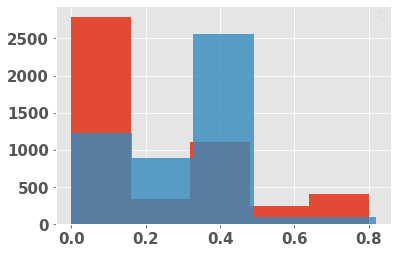

In [659]:
plt.hist(SUB_Conv_2PerUnique_4MORE['Agent_Negativity_Value'],bins=5)
plt.hist(SUB_Conv_2PerUnique_4MORE['Customer_Negativity_Value'],bins=5,alpha=0.8)
plt.legend()
# plt.scatter(SUB_Conv_2PerUnique['Customer_Negativity_Value'],SUB_Conv_2PerUnique['Conversation_Label'])

In [700]:
# max(literal_eval(SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Indices'].iloc[0])), SUB_Conv_2PerUnique_4MORE['Emotions_Sorted_Ints'].iloc[0][3]
literal_eval(SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Sentiment_List'].iloc[1])[-1]

1

In [720]:
## Labelling the conversations TYPE-I
# NOTE: The conversations will be labelled according to the sentiment of the final tweet sent by the customer
SUB_Conv_2PerUnique_4MORE['Conversation_Label'] = pd.Series([])
for i in range(SUB_Conv_2PerUnique_4MORE.shape[0]):
    SUB_Conv_2PerUnique_4MORE['Conversation_Label'].iloc[i] = max( (literal_eval(SUB_Conv_2PerUnique_4MORE['Customer_Tweet_Sentiment_List'].iloc[i])[-1], literal_eval(SUB_Conv_2PerUnique_4MORE['Agent_Tweet_Sentiment_List'].iloc[i])[-1]) )
    

In [721]:
SUB_Conv_2PerUnique_4MORE['Conversation_Label'].sum()

696.0

In [ ]:
## Labelling the conversations -- TYPE II
# NOTE: The conversations will be labelled according to the sentiment of the final TWO tweets sent by the customer
SUB_Conv_2PerUnique['Conversation_Label'] = pd.Series([])
for i in range(SUB_Conv_2PerUnique.shape[0]):
    temp_customer_ID = SUB_Conv_2PerUnique['Author_ID'].iloc[i]
    Tweet_Author_List = SUB_Conv_2PerUnique['Author_ID_List_Sorted'].iloc[i]
    customer_tweet_index = [j for j in range(len(Tweet_Author_List)) if Tweet_Author_List[j] == temp_customer_ID]
    Final_customer_tweet_index = max(customer_tweet_index)
    Final_customer_tweet_sent = np.int( SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[i][Final_customer_tweet_index] )
    SecLast_customer_tweet_sent = 0
    if len(customer_tweet_index) > 1:
        SecLast_customer_tweet_index = np.sort(customer_tweet_index)[1]
        SecLast_customer_tweet_sent = np.int( SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[i][SecLast_customer_tweet_index] )
    ConvLabel = Final_customer_tweet_sent + SecLast_customer_tweet_sent
    SUB_Conv_2PerUnique["Conversation_Label"].iloc[i] = ConvLabel

In [ ]:
SUB_Conv_2PerUnique[]

In [13]:
# Saving all this wonderful work you've done so far!!
SUB_Conv_2PerUnique.to_csv("SUB_Conv_2PerUnique.csv")   

## Basic Conversation Analysis -- THINK MVP!!!!
#### The basic analysis of a conversation can begin by asking "How many 'negative' tweets occured through out the conversation?" (STANDARDIZED BY THE LENGTH OF THE CONVERSATION) This can be applied to both the 'positive' and 'negative' conversations. The 'positive' conversation serves as a baseline to which some value between the 'positive' and 'negative' conversations can serve as the threshold which if suprpassed during the the conversation a warning is flagged for the CS agent

In [ ]:
os.chdir(data_generated_path)
SUB_Conv_2PerUnique = pd.read_csv('SUB_Conv_2PerUnique.csv')

In [667]:
SUB_Conv_2PerUnique_4MORE.shape

(4871, 26)

In [722]:
## Firstly one must consider that a conversation of length 1 (actually 2 tweets have been exchanged) is insufficient.
# Now, we crop the analysis for conversations with: 1) Final_Convo_length >= 2 2) Total number of coversations > NUM (ensure good statistics)
# Selecting Tweeter Conversations longer than 3 Tweets
SUB_Conv_2PerUnique_MORE = SUB_Conv_2PerUnique_4MORE[SUB_Conv_2PerUnique_4MORE["Final_Convo_Length"] >= 3]
print("Twitter Conversations with 4 or more Tweets=", SUB_Conv_2PerUnique_MORE.shape[0])

Twitter Conversations with 4 or more Tweets= 4871


In [723]:
## The Average "Sentiment" value for each conversation (sum of sentiment values divided by the total length of the conversation)

## ONLY RUN THIS LINE ONCE ********* AND ONLY RUN IT IF YOU ARE LOADING THE "SUB_Conv_2PerUnique" Dataframe
# SUB_Conv_2PerUnique_MORE['Emotions_Sorted_Ints'] = SUB_Conv_2PerUnique_MORE['Emotions_Sorted_Ints'].apply(lambda x: json.loads(x))

SUB_Conv_2PerUnique_MORE['Sentiment_Value'] = SUB_Conv_2PerUnique_MORE['Emotions_Sorted_Ints'].apply(lambda x: (sum(x)-x[0])/(len(x)-1))
#print(SUB_Conv_2PerUnique_MORE['Sentiment_Value'].unique())
#len(SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[7]), sum(SUB_Conv_2PerUnique['Emotions_Sorted_Ints'].iloc[7])

## Seperating the Resolved from the Unresolved Conversations
SUB_Conv_Resolved   = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE['Conversation_Label'] == 0]
SUB_Conv_UNResolved = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE['Conversation_Label'] == 1]
# Saving the Resolved and Unresolved Conversations with the specific length cut applied above (last time run it was 5)
SUB_Conv_Resolved.to_csv("SUB_Conv_Resolved_len5more.csv")
SUB_Conv_UNResolved.to_csv("SUB_Conv_UNResolved_len5more.csv") 

In [724]:
SUB_Conv_2PerUnique_MORE['Sentiment_Value'].unique(), SUB_Conv_Resolved.shape , SUB_Conv_UNResolved.shape

(array([0.33333333, 1.        , 0.66666667, 0.        , 0.25      ,
        0.5       , 0.2       , 0.16666667, 0.4       , 0.6       ,
        0.57142857, 0.8       , 0.28571429, 0.75      , 0.42857143,
        0.14285714, 0.625     , 0.45      , 0.86363636, 0.77777778,
        0.71428571, 0.55555556, 0.72727273, 0.83333333, 0.3       ,
        0.36363636, 0.875     ]), (4175, 27), (696, 27))

[ 3  4  5  6  7  8  9 10 11 15 20 22]


/home/george/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


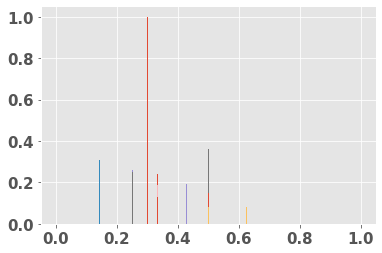

In [725]:
## Determine the optimal Negativity Cutoff Value for each tweet conversation length
bins = np.arange(0,1,0.001)
epsilon = 10**(-18)
convo_lengths = np.sort(SUB_Conv_2PerUnique_MORE['Final_Convo_Length'].unique())
crit_neg_values = pd.DataFrame(columns=['convo_lengths','num_res_convos','num_unres_convos','critical_neg_val','Resolved_frac','Unresolved_frac','Resolved_MIN_Probability'])
print(convo_lengths)
crit_neg_values['convo_lengths'] = convo_lengths



# print(convo_lengths)
for i in range(len(convo_lengths)):
    
    SUB_Conv_2PerUnique_MORE_temp = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE["Final_Convo_Length"] >= convo_lengths[i] ] # Gathering Conversations
    SUB_Conv_Resolved_temp   = SUB_Conv_2PerUnique_MORE_temp[SUB_Conv_2PerUnique_MORE_temp['Conversation_Label'] == 0]
    SUB_Conv_UNResolved_temp = SUB_Conv_2PerUnique_MORE_temp[SUB_Conv_2PerUnique_MORE_temp['Conversation_Label'] == 1]

    n_res = plt.hist(SUB_Conv_Resolved_temp['Sentiment_Value'], bins=bins, weights=np.ones(SUB_Conv_Resolved_temp.shape[0])/SUB_Conv_Resolved_temp.shape[0]) # hist. resolved
    n_unres = plt.hist(SUB_Conv_UNResolved_temp['Sentiment_Value'], bins=bins, weights=np.ones(SUB_Conv_UNResolved_temp.shape[0])/SUB_Conv_UNResolved_temp.shape[0]) # hist unresolved

    diff_n = np.zeros([len(n_res[0])])
    acc_n = np.zeros([len(n_res[0])])
    res_sum_array = np.zeros([len(n_res[0])])
    unres_sum_array = np.zeros([len(n_res[0])])
    res_sum_temp = 0
    unres_sum_temp = 0
    
    for j in range(len(n_res[0])):
        res_sum_temp += n_res[0][j]
        res_sum_array[j] = res_sum_temp
        unres_sum_temp += n_unres[0][j]
        unres_sum_array[j] = unres_sum_temp
        diff_n[j] = res_sum_temp - unres_sum_temp ## Is this equivalent to accuracy --> res_sum / (res_sum + unres_sum)?
        #acc_n[j] = res_sum_temp / (res_sum_temp + unres_sum_temp+epsilon)
    
    # maximum value index
    indices = [i for i, x in enumerate(list(diff_n)) if x == max(list(diff_n))]
    max_index = max(indices)
    crit_neg_values['critical_neg_val'].iloc[i] = bins[max_index]
    crit_neg_values['num_res_convos'].iloc[i] = SUB_Conv_Resolved_temp.shape[0]
    crit_neg_values['num_unres_convos'].iloc[i] = SUB_Conv_UNResolved_temp.shape[0]
    crit_neg_values['convo_lengths'].iloc[i] = convo_lengths[i]
    crit_neg_values['Resolved_frac'].iloc[i] = res_sum_array[max_index]
    crit_neg_values['Unresolved_frac'].iloc[i] = unres_sum_array[max_index]
    crit_neg_values['Resolved_MIN_Probability'].iloc[i] = res_sum_array[max_index] / (res_sum_array[max_index] + unres_sum_array[max_index])
    #crit_neg_values['Probability'].iloc[i] = acc_n[max_index]
    
# print(diff_n)
# max_index = np.argmax(diff_n)
# print("The maximum index value is = ", max_index)
# print("The maximum value is = ", diff_n[max_index])
# print("The Critical Neg. Value is =", n_res[0][max_index+1])
crit_neg_values.to_csv('Critical_Neg_Values.csv')

In [726]:
crit_neg_values

,convo_lengths,num_res_convos,num_unres_convos,critical_neg_val,Resolved_frac,Unresolved_frac,Resolved_MIN_Probability
0,3,4175,696,0.362,0.973174,0.045977,0.954887
1,4,955,296,0.284,0.86911,0.00337838,0.996128
2,5,205,117,0.284,0.77561,0,1
3,6,48,47,0.362,0.9375,0.212766,0.815029
4,7,13,26,0.362,1,0.153846,0.866667
5,8,4,12,0.362,1,0,1
6,9,1,9,0.362,1,0,1
7,10,1,6,0.362,1,0,1
8,11,0,5,0.362,0,0,NaN
9,15,0,3,0.399,0,0,NaN


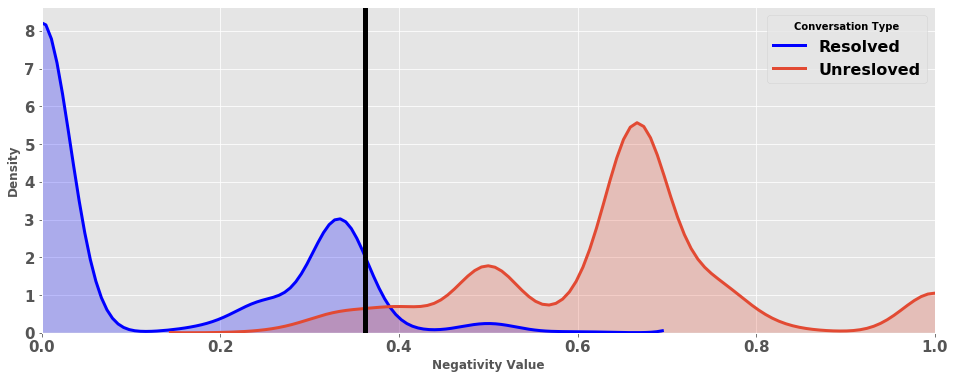

The Kuiper Statistic is: 0.9271966412003578
The Kuiper Probability of being draw from the same distribution: 0.0


In [746]:
# Draw the density plot
plt.figure(figsize=(16, 6))
sns.distplot(SUB_Conv_Resolved['Sentiment_Value'], hist = False, kde = True, kde_kws = {'shade': True,'linewidth': 3},label = 'Resolved',color='b')
sns.distplot(SUB_Conv_UNResolved['Sentiment_Value'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, label = 'Unresloved')

# Plot formatting

plt.legend(prop={'size': 16}, title = 'Conversation Type')
#plt.title('Density Plot with Multiple Airlines')
plt.axvline(x=0.362,lw=5,color='k')
plt.xlabel('Negativity Value')
plt.xlim([0,1])
plt.ylabel('Density')
plt.show()
# plt.figure(figsize=(16, 6))
# Importing and testing the distributions using a kuiper two test
from kuiper import kuiper_two
epsilon = 10**(-10)
D, fpp = kuiper_two(SUB_Conv_Resolved['Sentiment_Value'], SUB_Conv_UNResolved['Sentiment_Value'])
print("The Kuiper Statistic is:", D)
print("The Kuiper Probability of being draw from the same distribution:", fpp)

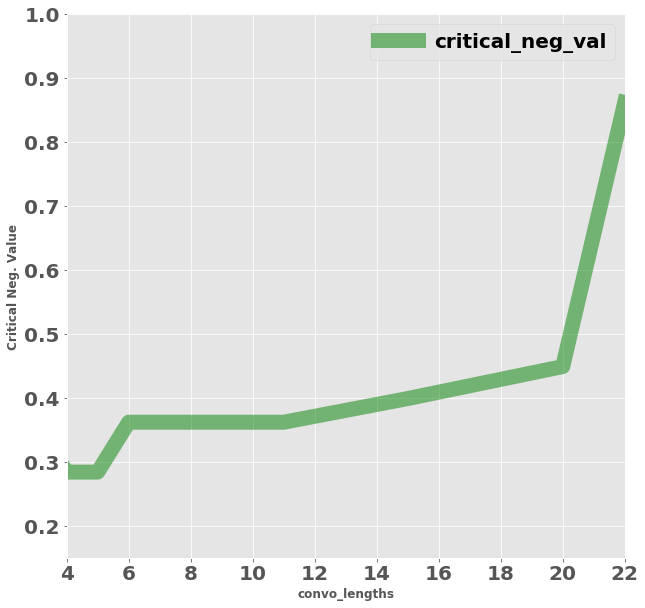

In [747]:
# Plotting the Critical Negative Value vs The Conversation Length
# plt.figure(figsize=(16, 16))
# sns.lineplot(x='convo_lengths',y='critical_neg_val',data=crit_neg_values)
crit_neg_values.plot(x="convo_lengths", y="critical_neg_val", kind="line", figsize=(10,10), fontsize=20, linewidth=15, color='g',alpha=0.5)
#crit_neg_values.plot(x="convo_lengths", y="Resolved_MIN_Probability", kind="line", figsize=(8,8), fontsize=20, linewidth=15, color='b',alpha=0.5)
plt.xlim(4,22)
plt.ylim(0.15,1)
plt.ylabel('Critical Neg. Value')
plt.legend(fontsize=20)

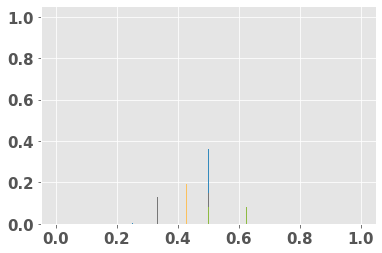

In [735]:
# Determining the probabilty distributions for a given length of a twitter conversation
bins = np.arange(0,1,0.001)
Probability_Distributions_ConvoLength = pd.DataFrame([])
Probability_Distributions_ConvoLength['bins'] = bins
#Probability_Distributions_ConvoLength['convo_lengths'] = convo_lengths

for i in range(len(convo_lengths)):
    
    SUB_Conv_2PerUnique_MORE_temp = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE["Final_Convo_Length"] >= convo_lengths[i] ] # Gathering Conversations
    SUB_Conv_Resolved_temp   = SUB_Conv_2PerUnique_MORE_temp[SUB_Conv_2PerUnique_MORE_temp['Conversation_Label'] == 0]
    SUB_Conv_UNResolved_temp = SUB_Conv_2PerUnique_MORE_temp[SUB_Conv_2PerUnique_MORE_temp['Conversation_Label'] == 1]

#     n_res = plt.hist(SUB_Conv_Resolved_temp['Sentiment_Value'], bins=bins, weights=np.ones(SUB_Conv_Resolved_temp.shape[0])/SUB_Conv_Resolved_temp.shape[0]) # hist. resolved
    n_unres = plt.hist(SUB_Conv_UNResolved_temp['Sentiment_Value'], bins=bins, weights=np.ones(SUB_Conv_UNResolved_temp.shape[0])/SUB_Conv_UNResolved_temp.shape[0]) # hist unresolved

    temp_prob_list = [0]
    res_sum_temp = 10**(-16)
    unres_sum_temp = 10**(-16)
    
    for j in range(len(n_res[0])):
        res_sum_temp += n_res[0][j]
        unres_sum_temp += n_unres[0][j]
        temp_prob_list.append(unres_sum_temp)
        
    temp_prob_list = temp_prob_list/unres_sum_temp # Normalizing the unresolved conversation count to be a probability
    col_name = "conv_len_%i" %(convo_lengths[i])
    insert_columns = i+1
    Probability_Distributions_ConvoLength.insert(i+1,col_name,temp_prob_list)

In [736]:
Probability_Distributions_ConvoLength

,bins,conv_len_3,conv_len_4,conv_len_5,conv_len_6,conv_len_7,conv_len_8,conv_len_9,conv_len_10,conv_len_11,conv_len_15,conv_len_20,conv_len_22
0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.001,1.103011e-16,1.042254e-16,1.017391e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16
2,0.002,1.103011e-16,1.042254e-16,1.017391e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16
3,0.003,1.103011e-16,1.042254e-16,1.017391e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16
4,0.004,1.103011e-16,1.042254e-16,1.017391e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16,1.000000e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.995,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
996,0.996,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
997,0.997,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
998,0.998,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


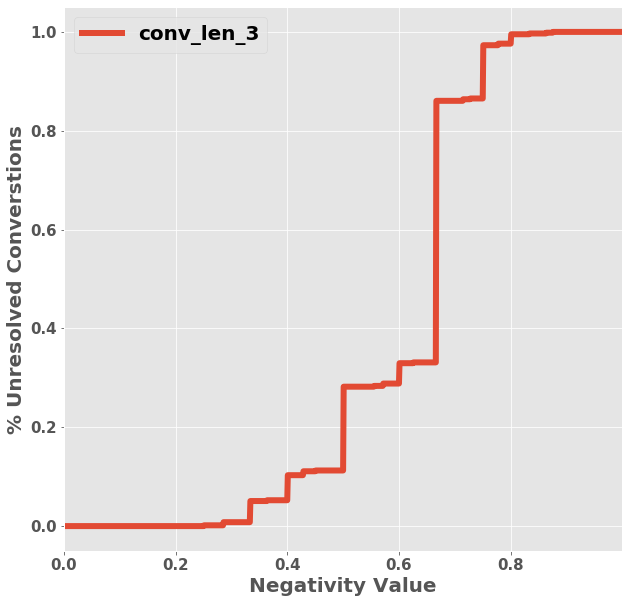

In [749]:
ax = Probability_Distributions_ConvoLength.plot(x='bins',y='conv_len_3', figsize=(10,10), lw = 6)
ax.set_xlabel("Negativity Value",size=20)
ax.set_ylabel("% Unresolved Converstions",size=20)
ax.legend(fontsize=20)

## Determining the most common words used in the tweets which lead to an unreseolved conversation
### Would be best to separate these tweets in to customer and agent and analyze them seperately


## -------------------------------------------------------------------------

In [ ]:
SUB_Conv_UNResolved.columns

In [ ]:
from ast import literal_eval
temp_list = literal_eval(SUB_Conv_UNResolved['Author_ID_List_Sorted'].iloc[0])
print(temp_list[0], temp_list[1])

In [ ]:
## Separating the conversations into customer and agent tweets
# author, conversation_tweet_num, tweet_text, emotional_Sent_score

# Need to convert the list of Authors back to a list (when it was saved it became a string)
SUB_Conv_UNResolved["Author_ID_List_Sorted"] = SUB_Conv_UNResolved["Author_ID_List_Sorted"].apply(lambda x: literal_eval(x))

UNResolved_Agent = pd.DataFrame([])
UNResolved_Agent['Conversation_ID'] = pd.Series([])
UNResolved_Agent['Agent_ID'] = pd.Series([])
UNResolved_Agent['Conversation_Tweet_Num'] = pd.Series([])
UNResolved_Agent['Tweet_Text'] = pd.Series([])
UNResolved_Agent['Sentiment_Score'] = pd.Series([])

UNResolved_Customer = pd.DataFrame([])
UNResolved_Customer['Conversation_ID'] = pd.Series([])
UNResolved_Customer['Customer_ID'] = pd.Series([])
UNResolved_Customer['Conversation_Tweet_Num'] = pd.Series([])
UNResolved_Customer['Tweet_Text'] = pd.Series([])
UNResolved_Customer['Sentiment_Score'] = pd.Series([])

agent_cntr = 0
custm_cntr = 0

for i in range(len(SUB_Conv_UNResolved)):
    tweet_conversation_ID = SUB_Conv_UNResolved['Unnamed: 0'].iloc[0]
    author_list_sorted_temp = SUB_Conv_UNResolved['Author_ID_List_Sorted'].iloc[i]
    tweet_list_sorted_temp  = SUB_Conv_UNResolved['Tweets_Sorted'].iloc[i]
    sentiment_scores_temp_sorted = SUB_Conv_UNResolved['Emotions_Sorted_Ints'].iloc[i]
    temp_customer_id = author_list_sorted_temp[0]
    temp_agent_id = author_list_sorted_temp[1]
    for j in range(len(author_list_sorted_temp)):
        if temp_customer_id == author_list_sorted_temp[j]:
            UNResolved_Customer['Conversation_ID'].iloc[custm_cntr] = tweet_conversation_ID
            UNResolved_Customer['Customer_ID'].iloc[custm_cntr] = temp_customer_id 
            UNResolved_Customer['Conversation_Tweet_Num'].iloc[custm_cntr] = j
            UNResolved_Customer['Tweet_Text'].iloc[custm_cntr] = tweet_list_sorted_temp[j]
            UNResolved_Customer['Sentiment_Score'].iloc[custm_cntr] = sentiment_scores_temp_sorted[j]
            custm_cntr += 1
        elif temp_agent_id == author_list_sorted_temp[j]:
            UNResolved_Agent['Conversation_ID'].iloc[cu_cntr] = tweet_conversation_ID
            UNResolved_Agent['Agent_ID'].iloc[custm_cntr] = temp_customer_id 
            UNResolved_Agent['Conversation_Tweet_Num'].iloc[custm_cntr] = j
            UNResolved_Agent['Tweet_Text'].iloc[custm_cntr] = tweet_list_sorted_temp[j]
            UNResolved_Agent['Sentiment_Score'].iloc[custm_cntr] = sentiment_scores_temp_sorted[j]
            custm_cntr += 1
            
            
            

Agent_IDs = SUB_Conv_UNResolved['Author_ID_List']

UNResolved_Agent[""]

for i in range(len(SUB_Conv_UNResolved.shape[0]))
    SUB_Conv_UNResolved

In [ ]:
# Collecting all the Unresolved tweets
UNRES_Tweets = []
for i in range(len(SUB_Conv_UNResolved)):
    UNRES_Tweets.append(SUB_Conv_UNResolved['Tweets'].iloc[i])

In [ ]:
UNRES_Tweets_PreProc = []
for i in range(len(UNRES_Tweets)):
    UNRES_Tweets_PreProc = UNRES_Tweets_PreProc + (text_processing(UNRES_Tweets[i]) )

In [ ]:
UNRES_Tweets_PreProc

In [ ]:
cv=CountVectorizer(max_df=0.85,stop_words="english")
word_count_vector=cv.fit_transform(UNRES_Tweets_PreProc)

In [ ]:
list(cv.vocabulary_.keys())[:30]

In [ ]:
i = 211
SUB_Conv_UNResolved.iloc[i]['Tweets_Sorted'] , SUB_Conv_UNResolved.iloc[i]['Emotions_Sorted']
# Unresloved Conversations = #80 #131 # 71 #79

In [ ]:
j = 86
SUB_Conv_Resolved.iloc[j]['Tweets_Sorted'] , SUB_Conv_UNResolved.iloc[i]['Emotions_Sorted']
# Resolved Coversations = 31(?), 43(simple but works), 44, 49, 52(simple), 53(validates the convo labeling), 

In [ ]:
## Plotting select tweets in a png file
## Plotting text to an image

from PIL import Image, ImageDraw, ImageFont

lines = ["@delta not a happy customer right now😧mobile app&amp;web said 12c and now I'm in knee cruncher. Gate agent said my mistake till showed my phone!",
  "@200576 Hi Don. I'm showing you are confirmed in 12C on DL1177 ATL-RDU. *ALS",
  '@Delta Nope she said no go and put me in 18d',
  "@200576 I do not see the update in our system. I'm showing you are currently onboard the aircraft in seat 12C. *ALS",
  '@Delta The seat was open and she just moved a lady into it.   This is horrible customer service.   And to be told my error!',
  '@200576 I am unable to communicate with the gate agent. You will have to provide your boarding pass to our (cont)... *ALS',
  '@200576 Corporate Customer Care Dept. https://t.co/fPLXqv8KGq for some sort of resolution.  *ALS']

Sent_list = ['Neg', 'Pos', 'Pos', 'Pos', 'Neg', 'Neg', 'Pos']

i_bad = 4 # This will be output by the model -- Negative Index

img = Image.new('RGB', (1800, 400), color = (240, 255, 240))
font = ImageFont.truetype('/usr/share/fonts/truetype/freefont/FreeSerif.ttf', 26) 
d = ImageDraw.Draw(img)
for i in range(len(lines)):
    message = lines[i]
    sent_temp = Sent_list[i]
    if i != i_bad:
        d.text((10,10+36*i),sent_temp+"--"+message, fill=(100,20,255), font=font)
    else:
        d.text((10,10+36*i),"*"+sent_temp+"--"+message+"*", fill=(255,20,20), font=font)
file_name = "Text_%i" %(i)
print(file_name)
img.save('pil_text.png')

In [ ]:
os.getcwd()

#### Plotting the histograms of the 'Sentiment Values' for Resolved and Unresolved conversations
bins_set = np.arange(0,1,0.15)
#print(bins_set)
SUB_Conv_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(15,15),label='Resolved',density=True)
SUB_Conv_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set, alpha=0.5, figsize=(15,15), label='Unresolved', density=True)

# Importing and testing the distributions using a kuiper two test
from kuiper import kuiper_two
epsilon = 10**(-10)
D, fpp = kuiper_two(SUB_Conv_Resolved['Sentiment_Value'], SUB_Conv_UNResolved['Sentiment_Value'])
print("The Kuiper Statistic is:", D)
print("The Kuiper Probability of being draw from the same distribution:", fpp)

# Examining the distributions using simple Gaussian Statisics
# Res_mean = np.mean(SUB_Conv_Resolved['Sentiment_Value'])
# Res_Std  = np.std(SUB_Conv_Resolved['Sentiment_Value'])
# UnRes_mean = np.mean(SUB_Conv_UNResolved['Sentiment_Value'])
# UnRes_Std = np.std(SUB_Conv_UNResolved['Sentiment_Value'])
# print("ResMEAN = ", Res_mean)
# print("ResSTD = ", Res_Std)
# Res3SIG_UB = Res_mean + 3*Res_Std
# print("Res3SIG_UB = ", Res3SIG_UB)
# print("UnResMEAN = ", UnRes_mean)
# print("UnResSTD = ", UnRes_Std)

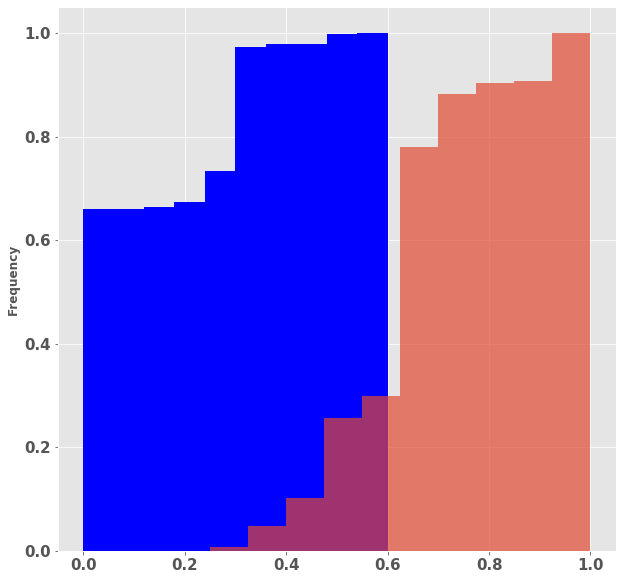

In [744]:
# plotting the cumulative distribution functions
bins_set = 10
SUB_Conv_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(10,10),label='Resolved',cumulative=True,density=True,color='blue')
SUB_Conv_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set,figsize=(10,10), label='Unresolved',cumulative=True,density=True,alpha=0.7)

In [ ]:
SUB_Conv_2PerUnique.iloc[7]

In [ ]:
i = 20
SUB_Conv_Unique.iloc[i], SUB_Conv_Unique.iloc[i].Tweets

In [ ]:
## Now collecting the longer conversations (take notice that the maximum conversation length is 8 tweets after initiation (9 in total))
# Begin with labelling all Tweets as resolved or not -- [resolved,unresolved] = [1,0] and non_issue = -1 (spam/comment etc.)
# NOTE: This is done manually by George J. Conidis 

# Selecting Tweeter Conversations longer than 3 Tweets
SUB_Conv_2PerUnique_MORE = SUB_Conv_2PerUnique[SUB_Conv_2PerUnique["Final_Convo_Length"] >= 2]
print("Twitter Conversations with 3 or more Tweets=", SUB_Conv_2PerUnique_MORE.shape[0])

## Seperating the Resolved from the Unresolved Conversations
SUB_Conv_MORE_Resolved   = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE['Conversation_Label'] == 0]
SUB_Conv_MORE_UNResolved = SUB_Conv_2PerUnique_MORE[SUB_Conv_2PerUnique_MORE['Conversation_Label'] == 1]

# Plotting the histograms of the 'Sentiment Values' for Resolved and Unresolved conversations
bins_set = np.arange(0,1,0.2)
#print(bins_set)
SUB_Conv_MORE_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(15,15),label='Resolved',density=True)
SUB_Conv_MORE_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set, alpha=0.5, figsize=(15,15), label='Unresolved', density=True)

# Importing and testing the distributions using a kuiper two test
from kuiper import kuiper_two
epsilon = 10**(-10)
D, fpp = kuiper_two(SUB_Conv_MORE_Resolved['Sentiment_Value'], SUB_Conv_MORE_UNResolved['Sentiment_Value'])
print("The Kuiper Statistic is:", D)
print("The Kuiper Probability of being draw from the same distribution:", fpp)


In [ ]:


# plotting the cumulative distribution functions
SUB_Conv_MORE_Resolved['Sentiment_Value'].plot.hist(bins=bins_set, figsize=(10,10),label='Resolved',cumulative=True,density=True)
SUB_Conv_MORE_UNResolved['Sentiment_Value'].plot.hist(bins=bins_set,figsize=(10,10), label='Unresolved',cumulative=True,density=True)


In [ ]:
print("The mean of the Sentiment_Value of the RESOLVED Convs:", SUB_Conv_MORE_Resolved['Sentiment_Value'].mean() )
print("The STD of the Sentiment_Value of the RESOLVED Convs:", SUB_Conv_MORE_Resolved['Sentiment_Value'].std() )
print("The mean of the Sentiment_Value of the UNRESOLVED Convs:", SUB_Conv_MORE_UNResolved['Sentiment_Value'].mean() )
print("The STD of the Sentiment_Value of the UNRESOLVED Convs:", SUB_Conv_MORE_UNResolved['Sentiment_Value'].std() )

In [ ]:
i = 41
SUB_Conv_Unique_5Tweets.iloc[i], SUB_Conv_Unique_5Tweets.Tweets.iloc[i], print(Labels_5Tweets['Label_Conv_Res1_Unres0'].iloc[i]), SUB_Conv_Unique_5Tweets["Convo_Length"].iloc[i]

Things to consider plotting and evaluating tonight

Examine the longer (tweets > 5) conversations and when the threshold is met for a toxic conversation.
Plot the negativity scores such that they are easily seen (normalized as well)
Q: Is the point of contact truly the desirable point to cut of a conversation? Or should the Unresolved distribution be examined such that a confidence value be estabilshed that only ZZ% of these conversations be allowed (integrate the number of conversations allowable up until that value) This can be plot as two curves and highlighting the limit as a vertical line which the confidence value (percentage of included Resolved and Unresolved texts are included)

Q: Is there an analysis which can be done for just two tweets by the customer? Is there a correlation?